In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes between those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.

We will first identify all patients with left-sided breast cancer, using the following primary site codes:
(C500-506, C508-C509) AND only consider left breast cases: LATERALITY == "Left: origin of primary" coded as 2.
Then we will split the above patient population into two groups as follows: The treatment group, defined as the patients receiving any form of radiation the control group, defined as the patients who did not receive any form of radiation Operationally, these groups are defined by looking at the column RADIATN, which has values:


| Code	| Description |
|:---------:|:--------------:|
|0	| None; diagnosed at autopsy |
|1	|Beam radiation |
|2	|Radioacative implants|
|3	|Radioisotopes|
|4	|Combination of 1 with 2 or 3|
|5	|Radiation, NOS - method or source not specified|
|6	|Other radiation (1973-1987 cases only)|
|7	|Patient or patient's guardian refused radiation therapy|
|8	|Radiation recommened, unknown if administered|
|9	|Unknown if radiation administered|


So that a value of 0 defines the control group, and the values (1,2,3,4,5,6) define the treatment group. We will then perform matching between the resulting treatment and control groups.

In [3]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\BREAST.txt']

In [4]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

dfbreast0 = seerhelp.make_clean_dataframe(breastfiles[0])
dfbreast1 = seerhelp.make_clean_dataframe(breastfiles[1])
dfbreast2 = seerhelp.make_clean_dataframe(breastfiles[2])
dfbreast3 = seerhelp.make_clean_dataframe(breastfiles[3])

dfbreast = pd.concat([dfbreast0, dfbreast1, dfbreast2,
                     dfbreast3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfbreast.shape)

del dfbreast0
del dfbreast1
del dfbreast2
del dfbreast3

(1448798, 141)


In [5]:
dfbreast.LATERAL.value_counts()

Left origin of primary                                                        730569
Right origin of primary                                                       702454
Paired site, but no information concerning laterality; midline tumor           12729
Only one side involved, right or left origin unspecified                        1667
Bilateral involvement, lateral origin unknown; stated to be single primary      1379
Name: LATERAL, dtype: int64

In [7]:
leftfilter = dfbreast.LATERAL.str.contains('left origin of primary',case=False,na=False)
leftfilter.sum()

730569

In [8]:
mask = (dfbreast['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfbreast['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfbreast['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfbreast['CSTUMSIZ'] != "Not applicable") & \
(dfbreast['AGE_DX'] != "Unknown age") & \
(dfbreast['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfbreast['YEAR_DX'] >= 2004) & \
(dfbreast['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfbreast['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfbreast['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfbreast['CSTUMSIZ'] != "Not applicable") & \
(dfbreast['YR_BRTH'] != 'Unknown year of birth') & \
(dfbreast['CSTUMSIZ'] != 'Not applicable') & \
(dfbreast['CSTUMSIZ'] != 996) & \
(dfbreast['CSTUMSIZ'] != 997) & \
(dfbreast['CSTUMSIZ'] != 998) & \
(dfbreast['REC_NO'] == 1) & \
(leftfilter)

dfbreast = dfbreast[mask]




In [11]:
non_rad = dfbreast.RADIATN.str.contains('None',case=False,na=False)
refused_rad = dfbreast.RADIATN.str.contains('refused',case=False,na=False)
unknown_rad = dfbreast.RADIATN.str.contains('Unknown',case=False,na=False)

In [13]:
dfbreastcontrol = dfbreast[non_rad | refused_rad].copy()
dfbreasttreatment = dfbreast[~(non_rad) & ~(refused_rad) & ~(unknown_rad)].copy()

In [14]:
print(dfbreastcontrol.shape, dfbreasttreatment.shape)

(125038, 141) (129497, 141)


## <font color='steelblue'>So we are going to match patients in the control group with their nearest neighbors in the treatment group</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do some preprocessing of the data. The first step is to "one-hot-encode" the categorical features.

In [15]:
dfbreastcontrol.set_index('PUBCSNUM', inplace=True)
dfbreasttreatment.set_index('PUBCSNUM', inplace=True)

controlindices = dfbreastcontrol.index
treatmentindices = dfbreasttreatment.index

catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


dfpop = pd.concat([dfbreastcontrol, dfbreasttreatment],verify_integrity=True)

## <font color='steelblue'>Before matching, let's look at the Kaplan-Meier curves</font>

In [16]:
resgoodcontrol = pd.concat([pd.get_dummies(dfbreastcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfbreasttreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

resgoodcontrol['YR_BRTH'] = dfbreastcontrol['YR_BRTH']
resgoodcontrol['AGE_DX'] = dfbreastcontrol['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodcontrol['YEAR_DX'] = dfbreastcontrol['YEAR_DX']
resgoodcontrol['CSTUMSIZ'] = dfbreastcontrol['CSTUMSIZ']
resgoodcontrol['lat'] = dfbreastcontrol['lat']
resgoodcontrol['lng'] = dfbreastcontrol['lng']
resgoodcontrol['srv_time_mon'] = dfbreastcontrol['srv_time_mon']


resgoodtreatment['YR_BRTH'] = dfbreasttreatment['YR_BRTH']
resgoodtreatment['AGE_DX'] = dfbreasttreatment['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodtreatment['YEAR_DX'] = dfbreasttreatment['YEAR_DX']
resgoodtreatment['CSTUMSIZ'] = dfbreasttreatment['CSTUMSIZ']
resgoodtreatment['lat'] = dfbreasttreatment['lat']
resgoodtreatment['lng'] = dfbreasttreatment['lng']
resgoodtreatment['srv_time_mon'] = dfbreasttreatment['srv_time_mon']


resgoodpop['YR_BRTH'] = dfpop['YR_BRTH']
resgoodpop['AGE_DX'] = dfpop['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodpop['YEAR_DX'] = dfpop['YEAR_DX']
resgoodpop['CSTUMSIZ'] = dfpop['CSTUMSIZ']
resgoodpop['lat'] = dfpop['lat']
resgoodpop['lng'] = dfpop['lng']
resgoodpop['srv_time_mon'] = dfpop['srv_time_mon']

### <font color='steelblue'>After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

Below is how it looks **before** matching patients in the control and treatment groups together in pairs.

In [17]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All left-sided breast');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group)')
#ax = kmfpop.plot()
#ax = kmfcontrol.plot()
#kmftreatment.plot(ax=ax)
#plt.title("Left-sided breast cancer patients Kaplan-Meier Curve (95% CI) \n Pre-Matching");

<lifelines.KaplanMeierFitter: fitted with 129497 observations, 116669 censored>

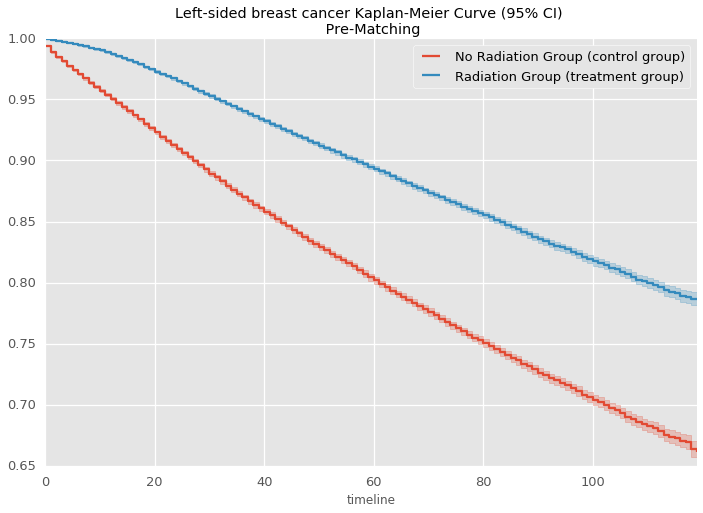

In [18]:
ax = kmfcontrol.plot()
kmftreatment.plot(ax=ax)
plt.title("Left-sided breast cancer Kaplan-Meier Curve (95% CI) \n Pre-Matching");

## <font color='steelblue'>Clearly, there is a huge benefit to receiving radiation</font>

However, one could logically argue that it is not radiation treatment that is leading to the better survival prognosis, but rather some other feature that leads to better prognosis is also leading to a greater likelihood of receiving radiation therapy. So that we are not really comparing apples to apples when we calculate these two survival curves. To answer this objection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the posistive effects of radiation.

In [19]:
resgoodpop['YR_BRTH'] = resgoodpop['YR_BRTH'].astype('int')
resgoodpop['AGE_DX'] = resgoodpop['AGE_DX'].astype('int')
resgoodpop['CSTUMSIZ'] = resgoodpop['CSTUMSIZ'].astype('float')
resgoodpop['lat'] = resgoodpop['lat'].astype('float')
resgoodpop['lng'] = resgoodpop['lng'].astype('float')
resgoodpop['srv_time_mon'] = resgoodpop['srv_time_mon'].astype('float')

newcolumns = list(resgoodpop.columns)


newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Female')

resgreatpop = resgoodpop[newcolumns].copy()

In [20]:
resgreatpop['PUBCSNUM'] = resgreatpop.index
leaguefilter = (resgreatpop['PUBCSNUM'].loc[treatmentindices])
resgreatpop['League'] = resgreatpop['PUBCSNUM'].isin(treatmentindices).astype('int')
del resgreatpop['PUBCSNUM']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This brute force method of finding similar patients characterized by points in a high-dimensional space is possible for thsi data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardization, **YR_BRTH** would contribute much more to the distance between patients than **AGE_DX**. the result of standardization (or Z-score normalization) is that features will be rescaled so that they will have the properties of a standard normal distribution with

$
\mu = 0$ and $\sigma = 1$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard deviation scores (also called z-scores) are then calculated as follows:

$
z_{i} = \frac{x_{i} -\mu}{\sigma}
$

In [22]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[-0.08351446 -0.34425379  0.88890672 ..., -0.44205836  0.84332737
   1.4115178 ]
 [-0.08351446 -0.34425379  0.88890672 ..., -0.39939058  0.85793605
   1.43914214]
 [-0.08351446 -0.34425379 -1.12497744 ..., -0.3567228   0.84332737
   1.4115178 ]
 ..., 
 [-0.08351446 -0.34425379  0.88890672 ..., -0.05804836 -1.51397547
   0.44581432]
 [-0.08351446 -0.34425379  0.88890672 ...,  0.83797497 -1.50646777
   0.63377969]
 [-0.08351446 -0.34425379 -1.12497744 ..., -0.69806502 -1.39163386
   0.6043983 ]]


In [23]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

## <font color='steelblue'>Here is a video explaining the construction of a KDTree</font>

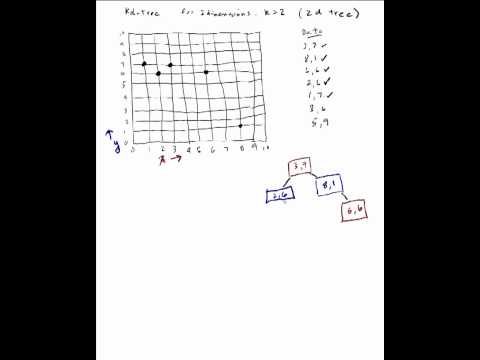

In [24]:
from IPython.display import YouTubeVideo
YouTubeVideo('LdaL-l2S76c')

In [25]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

### <font color='steelblue'>Finding the distances to all of the 4 nearest neighbors for each patient took about one hour. That may sound like a long time, but is nothing compared to a brute force method.

In [68]:

dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [69]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 1)

dist1filter = (dftreeleague['distance_1'] <= .5)
dist2filter = (dftreeleague['distance_2'] <= .5)
dist3filter = (dftreeleague['distance_3'] <= .5)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 1)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 1)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
PUBCSNUM,,,
7006495,93416670,0.449665,1
8361617,93386866,0.489732,1
11734799,92034674,0.172058,1
11735426,11738703,0.313372,1
11735672,11741966,0.301413,1
11735974,11734918,0.056895,1
11736143,11743779,0.335930,1
11736154,92012002,0.456247,1
11737673,92065220,0.314939,1


In [70]:

onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodcontrolteams = list(dd.keys())

goodtreatmentteams = list(dd.values())
matches = list(set([item for sublist in goodtreatmentteams for item in sublist]))

treatmentindices = matches
controlindices = goodcontrolteams
print(len(treatmentindices))
print(len(controlindices))

10000
9521


## <font color='steelblue'>Need to do a one-to-one matching (where each member of the control group is matched to one and only one member of the treatment group, and vice-versa</font>

In [71]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_c_t = {}

for key, value in d_one_to_one.items():
    if value not in d_c_t.values():
        d_c_t[key] = value
        
controlindices = list(d_c_t.keys())
treatmentindices = list(d_c_t.values())     

In [72]:
controlindices = list(d_c_t.keys())
treatmentindices = list(d_c_t.values())

print(len(controlindices), len(treatmentindices))

8568 8568


So we have 8568 control patients matched very closely (distance less than .5 in the high-dimensional space) to 8568 treatment patients. This is a good-sized group and will allow us to draw definitive statistical inferences.

## <font color='steelblue'>Now here is the Kaplan-Meier plot for the post-matching treatment and control groups</font>



In [73]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");

<lifelines.KaplanMeierFitter: fitted with 8568 observations, 8014 censored>

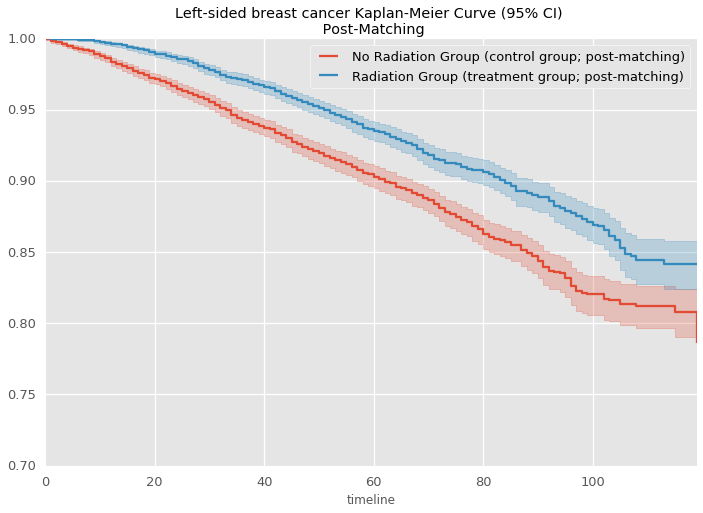

In [74]:
ax = kmfcontrolpost.plot()
kmftreatmentpost.plot(ax=ax)
#kmfcontrol.plot(ax=ax)
#kmftreatment.plot(ax=ax)
plt.title("Left-sided breast cancer Kaplan-Meier Curve (95% CI) \n Post-Matching");

## <font color='steelblue'>Because of the matching, the observed differences in the Kaplan-Meier estimates of the survival curves for the control and treatment groups clearly show that there is a real effect and real benefit to having radiation for left-sided breast cancer survival.</font>

### <font color='steelblue'>Now let's perform some paired t-tests to see if there is any demonstrable difference for some characteristics of interest</font>

You may suspect that some of the patients in the control group mayh have opted out of radiation because they may have already been near the end of life and did not want to go through with the treatment (but our matching should have taken care of and accounted for this possibility; let's see if a t-test based on **AGE_DX** can show that this is **not** the case).

In [75]:
control_age_dx = resgoodpop['AGE_DX'].loc[controlindices]
treatment_age_dx = resgoodpop['AGE_DX'].loc[treatmentindices]
dfage_comp = pd.DataFrame({'control_id': control_age_dx.index,
                          'control_age_dx': control_age_dx.values,
                          'treatment_id': treatment_age_dx.index,
                          'treatment_age_dx':treatment_age_dx.values })
dfage_comp['c_minus_t_age'] = dfage_comp.control_age_dx - dfage_comp.treatment_age_dx

## <font color='steelblue'>Two-sample T-test</font>

A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same. 

In [76]:
import scipy.stats as stats
stats.ttest_ind(a=dfage_comp.control_age_dx.as_matrix(), 
               b=dfage_comp.treatment_age_dx.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.051834781232340976, pvalue=0.95866094571478966)

The test yields a p-value of 0.958, which means that there is a 95.8% chance we'd see sample data this far apart if the two groups actually have identical **AGE_DX** distributions. We certaintly cannot reject the null hypothesis; our matching worked and we can guarantee that the differing survival curves for the groups are not influenced by **AGE_DX**.

## <font color='steelblue'>Paired T-Test</font>

The basic two sample t-test is designed for testing differences beween independent groups. In some cases, you might be interested in testing differences between samples of the same group at different points in time. In observational studies like those using the SEER data, the matched pairs in the control and treatment groups are considered for the purposes of paired t-tests to represent the same entity. Let's now see if there is any significant difference in **AGE_DX** between the treatment and control groups using a paired t-test

In [77]:
stats.ttest_rel(a = dfage_comp.control_age_dx.as_matrix(),
                b = dfage_comp.treatment_age_dx.as_matrix())

Ttest_relResult(statistic=0.4125728369528634, pvalue=0.67992992990682377)

## <font color='steelblue'>The paired T-Test also indicates that we actually do not have enough evidence to reject the null hypothesis.</font>

In [78]:
apost = dftreeleague['AGE_DX'][treatmentindices]
bpost = dftreeleague['AGE_DX'][controlindices]

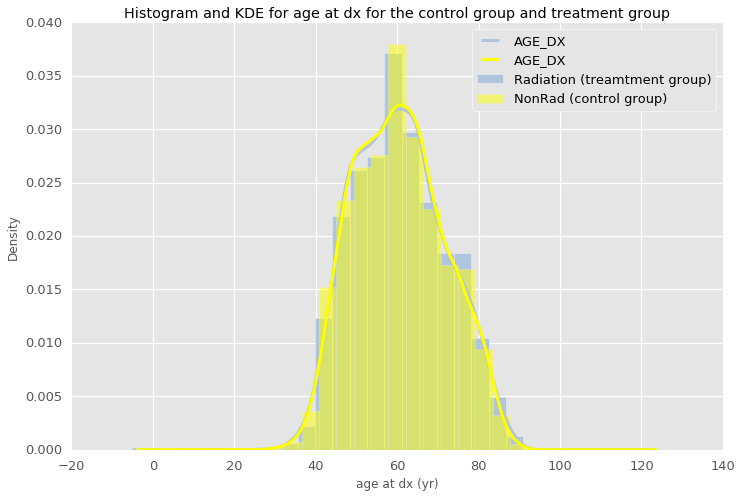

In [79]:

ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treamtment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax)
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax)
plt.title('Histogram and KDE for age at dx for the control group and treatment group')
plt.xlabel('age at dx (yr)')
plt.legend();

In [80]:
dfage_comp.control_age_dx.describe()

count    8568.000000
mean       60.562092
std        11.265470
min        27.000000
25%        52.000000
50%        60.000000
75%        68.000000
max        91.000000
Name: control_age_dx, dtype: float64

In [81]:
dfage_comp.treatment_age_dx.describe()

count    8568.000000
mean       60.553221
std        11.135160
min        28.000000
25%        52.000000
50%        60.000000
75%        68.000000
max        92.000000
Name: treatment_age_dx, dtype: float64

## <font color='steelblue'>Who is more likely to have insurance: Treatment (treated with rad) or Control (not treated with rad) left-sided breast cancer patients</font>

Silly question!!! Just illustrating the methodology

We will answer this question using Bayesian A/B testing.

We can use Bayesian A/B testing for all questions with a binary outcome, where either the desired event occured or not, or where  the desired feature is present or not.

In [82]:
dfbayes = dfbreast.set_index('PUBCSNUM').copy()

# the matched treatment patients insurance status; ignores the missing values
dfbayes['INSREC_PUB'][treatmentindices].value_counts()
# so the probability a treatment patient is insured is

Insured                     5156
Insured/No specifics         786
Any Medicaid                 253
Insurance status unknown      62
Uninsured                     45
Name: INSREC_PUB, dtype: int64

In [83]:
treatmentinsured = dfbayes['INSREC_PUB'][treatmentindices].value_counts()['Insured']
treatmenttotal = dfbayes['INSREC_PUB'][treatmentindices].value_counts().sum()
probtreatment = treatmentinsured/treatmenttotal
probtreatment

0.81815296731196441

In [84]:

controlinsured = dfbayes['INSREC_PUB'][controlindices].value_counts()['Insured']
controltotal = dfbayes['INSREC_PUB'][controlindices].value_counts().sum()
probcontrol = controlinsured/controltotal
probcontrol

0.7973337565465799

## <font color='steelblue'>Can use Bayesian A/B testing to see if we hvae enough data to see if the probability difference of having insurance between treatment and control groups for left-sided breast cancer patients is significant or not (a real effect or dur to chance and small numbers).</font>

In [85]:
TREATMENT_INSURED = treatmentinsured
CONTROL_INSURED = controlinsured
TREATMENT_TOTAL = treatmenttotal
CONTROL_TOTAL = controltotal

from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_treatment = beta(alpha_prior + TREATMENT_INSURED, beta_prior + TREATMENT_TOTAL - TREATMENT_INSURED)

posterior_control = beta(alpha_prior + CONTROL_INSURED, beta_prior + CONTROL_TOTAL - CONTROL_INSURED)


samples = 2000000

samples_posterior_treatment = posterior_treatment.rvs(samples)

samples_posterior_control = posterior_control.rvs(samples)

(samples_posterior_treatment > samples_posterior_control).mean()

0.99852249999999998

## <font color='steelblue'>So we can say that we are 99.8% certain that patients receiving radiation (as a group) are more likely than patients that do not receive radiation (as a group) to have health insurance.</font>

Shameful. If the patients  that did not have health insurance had in fact been insured, it is almost certain that their prognosis would have been better (they likely would have opted for radiation treatment). Infuriating.

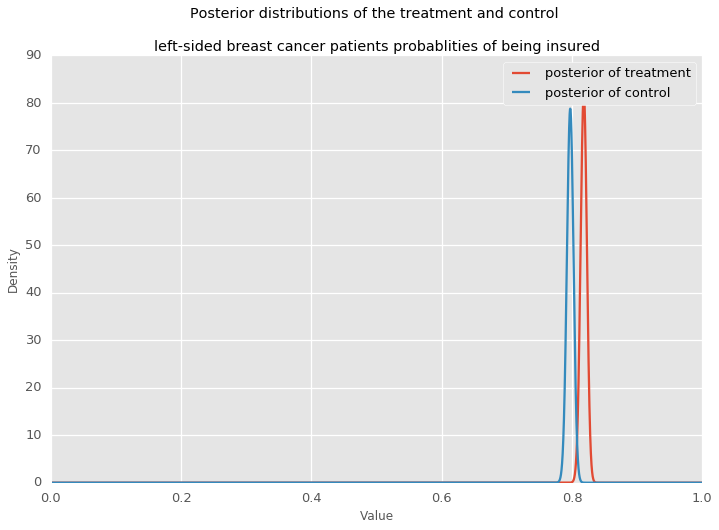

In [87]:
x = np.linspace(0,1, 50000)
plt.plot(x, posterior_treatment.pdf(x), label='posterior of treatment')
plt.plot(x, posterior_control.pdf(x), label='posterior of control');
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("""Posterior distributions of the treatment and control \n 
left-sided breast cancer patients probablities of being insured""")
plt.legend();


In [89]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

dfbreast0 = seerhelp.make_clean_dataframe(breastfiles[0])
dfbreast1 = seerhelp.make_clean_dataframe(breastfiles[1])
dfbreast2 = seerhelp.make_clean_dataframe(breastfiles[2])
dfbreast3 = seerhelp.make_clean_dataframe(breastfiles[3])

dfbreastorig = pd.concat([dfbreast0, dfbreast1, dfbreast2,
                     dfbreast3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfbreastorig.shape)

del dfbreast0
del dfbreast1
del dfbreast2
del dfbreast3

(1448798, 141)


In [90]:
dfbreastorig = dfbreastorig.set_index('PUBCSNUM',drop=False)

## <font color='steelblue'>Another question we can ask:</font>

Are left-sided breast cancer patients receiving radiation more likely than their non-radiation matched control patients to have secondary malignancies? Interesting question.

In [91]:
dfbreastorig['REC_NO'].loc[treatmentindices].value_counts()

1    8568
2     310
3      14
Name: REC_NO, dtype: int64

In [92]:
dfbreastorig['REC_NO'].loc[controlindices].value_counts()

1    8568
2     591
3      23
Name: REC_NO, dtype: int64

## <font color='steelblue'>Chi-Squared Goodness-of-Fit Tests</font>

The chi-squared goodness-of-fit test is an analog of the one-way t-test for categorical variables: it tests whether the distribution of sample categorical data matches an expected distribution. Tests dealing with categorical variables are based on variable counts instead of the actual value of the variables themselves.

In [93]:
recnotreatment = dfbreastorig['REC_NO'].loc[treatmentindices].value_counts()
recnocontrol = dfbreastorig['REC_NO'].loc[controlindices].value_counts()


stats.chisquare(recnotreatment.as_matrix(), recnocontrol.as_matrix())

Power_divergenceResult(statistic=137.12749209151769, pvalue=1.6716426137575116e-30)

In [94]:
stats.chisquare(recnocontrol.as_matrix(), recnotreatment.as_matrix())

Power_divergenceResult(statistic=260.49861751152076, pvalue=2.7129634051959643e-57)

## <font color='steelblue'>So left-sided breast cancer patients who do not receive radiation are more likely to develop secondary malignancies</font>

## <font color='steelblue'>Another question: Is there a significant difference in marital status between the two groups?</font>

Sometimes cancer patients undergo treatment not so much for themselves but for their spouses, family, support group. Let's test to see if the radiation group has a statistically different distribution from the control group for the categorical variable **MAR_STAT**.

## <font color='steelblue'>Chi-Squared Goodness-of-Fit Tests</font>

The chi-squared goodness-of-fit test is an analog of the one-way t-test for categorical variables: it tests whether the distribution of sample categorical data matches an expected distribution. Tests dealing with categorical variables are based on variable counts instead of the actual value of the variables themselves.

In [88]:
marstattreatment = dfbreast['MAR_STAT'].loc[treatmentindices].value_counts()
marstattreatment

KeyError: 'None of [[68654122, 11774809, 71305177, 35810825, 12984803, 41714999, 35783017, 19941142, 51085905, 52111689, 44168762, 5319399, 76139589, 41681491, 26822804, 36995388, 35730658, 11774091, 44049494, 67458566, 70030044, 70030877, 68685607, 94688515, 18858730, 68857794, 71441381, 68857468, 12927945, 51177692, 78157058, 99369663, 98638882, 5379393, 99263663, 12912007, 44021461, 50194677, 94546746, 11845312, 67371270, 51082778, 51191844, 70100161, 70112901, 71395090, 89722752, 52150184, 6127602, 41818676, 5282518, 76002020, 70029374, 44060327, 99355022, 11739448, 79047139, 19945508, 5380716, 70169600, 5344097, 81077166, 92111130, 93398096, 12860276, 75191370, 27980649, 36843864, 34714499, 99288558, 93294748, 72822256, 27837974, 92184602, 27840208, 98688562, 66083029, 35862413, 68849061, 71581434, 77160044, 52063142, 35720104, 18867359, 41851369, 36974075, 67237720, 68762972, 52000989, 65908443, 19909890, 65894806, 78190801, 92034674, 80170603, 67218459, 67490330, 41027033, 20005995, 35811973, 65997403, 15290682, 5385772, 72687319, 92017421, 44183120, 50228170, 51037365, 4495758, 5345236, 6193305, 52184096, 51161382, 80189735, 6154889, 6244438, 75202557, 51005575, 81087903, 68622667, 70169662, 51225252, 27837345, 94754327, 92219183, 79202761, 70081135, 72801402, 35674752, 19992990, 93376695, 35886316, 51015794, 27881462, 94690039, 41683274, 66038241, 51105822, 95862325, 44076051, 68803241, 27956573, 13019461, 80161134, 5329014, 41712869, 98653508, 52018327, 41834298, 4512125, 53034135, 50228767, 66022644, 68673367, 66097884, 65986017, 67496852, 65907995, 99309707, 94688001, 75156663, 51180704, 44166897, 27848623, 35763617, 6128399, 41831173, 68747373, 66105665, 19917231, 92181319, 5292015, 27841285, 97912766, 36998869, 77161603, 5355636, 68662832, 81069391, 71541891, 92050106, 66100608, 67306894, 52011423, 41732426, 19941799, 13028470, 95862226, 5354252, 98541156, 13042091, 67245529, 66079258, 69933488, 44162515, 36879707, 81082403, 41716995, 80143103, 18908923, 94622405, 36901445, 71459087, 48201834, 70041942, 13021787, 51042738, 99368505, 4494565, 5327308, 44160518, 67406768, 71550367, 39201567, 44188125, 27955880, 67235218, 68756489, 79065778, 92059812, 92063023, 39159683, 70193573, 68831322, 71424614, 94755289, 5344051, 51019766, 69991772, 71381267, 69965851, 81002674, 27921551, 52128288, 52221866, 52084555, 5358369, 72720403, 35773292, 68604738, 69995427, 94647717, 52209106, 13017662, 18892251, 35725753, 97792433, 35738926, 67308288, 19886245, 77090466, 97924184, 92239554, 53030545, 66062503, 66126308, 76134918, 80143157, 93288786, 11738121, 71384701, 67214716, 93436729, 52016716, 5321703, 76037796, 27895483, 35761729, 95773917, 71567184, 92120825, 78181076, 70175885, 94610834, 92083264, 51172452, 68662019, 68797536, 97913435, 39220564, 5295708, 76069966, 64738512, 12962203, 4523785, 68663646, 53078246, 5395612, 93307279, 78147706, 93432793, 97866712, 93429614, 94645231, 36866336, 52219864, 93336673, 35850604, 71564055, 98654556, 65879413, 68807092, 12889712, 79201027, 44121798, 27817624, 69983126, 39122498, 6193181, 76022882, 27807221, 41765404, 68726637, 66050098, 11809025, 39015368, 98630182, 5394751, 5412453, 76134750, 93255977, 67373624, 27884714, 98529026, 71328054, 13026916, 92197267, 77030209, 11742258, 95806347, 98677521, 36848735, 53153536, 94561777, 71291654, 52087542, 94607525, 51080550, 36937582, 39023633, 19928376, 35723347, 67267538, 36966242, 44188103, 76203956, 98698812, 95840434, 36957567, 12888572, 67467124, 53013827, 5391862, 39186723, 98507098, 99385424, 12895397, 39010212, 72715766, 51160862, 13010894, 50202918, 12945860, 26823089, 12931202, 6141235, 12866907, 97924695, 92132942, 67369500, 11738242, 6206940, 68648010, 92134794, 35716981, 41800375, 93315693, 39183582, 93348595, 13033263, 44080769, 79053545, 5279045, 93365955, 4520951, 52100282, 94695167, 6213261, 5337495, 11815817, 32190047, 11778966, 39110033, 71568432, 71567171, 77149051, 35878355, 36957413, 93468823, 67366201, 98631552, 68802136, 94596903, 27926915, 70181051, 5259729, 51151660, 41817726, 67490278, 51096020, 69928817, 52118756, 6125514, 65861584, 68588999, 51085978, 95760230, 35673640, 35842803, 71540210, 76040964, 52204730, 95790989, 41680612, 53156967, 94721698, 53051948, 64739001, 4540543, 95753219, 41681299, 39176066, 12914436, 66111305, 11866164, 71511668, 95796729, 51008644, 99369247, 12866142, 41680043, 95814478, 93406615, 93270935, 93301249, 6171042, 97805104, 68707711, 68677228, 71401394, 51114677, 98512851, 27814212, 76085127, 20044910, 44159742, 65863030, 11795228, 97895910, 93357882, 41713840, 70148159, 77004943, 53145822, 35870420, 35738396, 12930568, 50192426, 67246389, 99253513, 99323241, 64738469, 52057987, 92130628, 6221366, 67490743, 27984783, 95814215, 68786980, 92143561, 95783445, 72707487, 53046624, 41704756, 35680646, 72719990, 19958756, 67271674, 70051463, 98615298, 53084621, 65867670, 94578206, 75192021, 68815296, 95843314, 65859364, 50193402, 65972231, 77012384, 66001084, 67432854, 79167470, 41699478, 41033475, 92113661, 5344326, 50200434, 19836649, 94733600, 66083271, 66028645, 76093983, 52207863, 27840240, 72696342, 11806182, 12965218, 67229387, 11782095, 51051301, 71325252, 44029153, 99303583, 12974495, 99291639, 65893395, 77173786, 81061867, 51017553, 70006200, 27965611, 51215491, 71578050, 65993683, 71358993, 71528613, 71584559, 35727315, 19914717, 70126749, 27884897, 66040983, 98655639, 41804679, 92108074, 19950829, 11861086, 71537901, 76219189, 70200445, 81079985, 5367153, 50212757, 39222098, 51194466, 19901754, 66012364, 65907834, 51040310, 67334697, 92170559, 76193576, 12905363, 52032241, 99314410, 12950395, 67434238, 4538121, 44185744, 27836374, 72816140, 67447752, 71426628, 19938311, 71432218, 5397047, 11793702, 76101299, 77065074, 67386572, 92087349, 68670387, 77129806, 92063956, 41670247, 93439769, 71478905, 70092104, 11742081, 97761199, 95822390, 65918218, 39183010, 39175196, 94586596, 41681319, 52185024, 80188701, 12912319, 36851615, 20012154, 98594500, 76092953, 41765499, 36881889, 72733900, 36964482, 76201275, 77080923, 93305984, 72784606, 4520102, 6200824, 66034517, 4466607, 35716948, 5377895, 52078577, 44154264, 52101515, 92202770, 52117206, 68655828, 70035018, 12925547, 44188407, 52159626, 44028245, 79169129, 18844549, 71376610, 18863946, 95826294, 52012177, 70214279, 5371066, 5301642, 50187106, 92220978, 12849673, 12873039, 70019978, 44149845, 41871384, 70069228, 93418945, 94619945, 67298404, 12981276, 39114295, 95766246, 53113149, 6212136, 50218974, 65952026, 68722856, 12848796, 69934355, 95856662, 97859946, 39199927, 50199651, 6162739, 5343703, 19908442, 93381835, 53032953, 69942145, 95980242, 41033004, 70219493, 67450458, 51198497, 52103787, 97836261, 71469103, 67445893, 12851360, 71351047, 35887082, 70193571, 35673110, 94731498, 68846656, 67349624, 65894809, 95778973, 66067470, 52072263, 76153927, 99319699, 65870027, 67216599, 99385343, 94629052, 52146058, 93473467, 19912277, 93444369, 35760922, 11740732, 94641349, 72768102, 52085334, 51027710, 39108361, 95895794, 72828392, 36981637, 41743821, 27949239, 76098013, 93363365, 41773058, 52038110, 92223919, 41040544, 12974832, 44219421, 53068329, 94710767, 11740671, 5387417, 41781015, 67260056, 71298475, 44055396, 94524726, 93483403, 68663782, 70124638, 68658330, 94509656, 12924862, 11840660, 76138087, 41699358, 71336762, 75160446, 51144140, 12964671, 11779995, 41743935, 92182084, 41057839, 5376494, 22118111, 75215588, 37003647, 77032559, 68764100, 67425297, 72731400, 93418560, 71490640, 44204699, 70046450, 67381650, 71584039, 76065825, 68706342, 6219362, 67372351, 68742961, 41775493, 36850767, 95822834, 93464070, 68597287, 76205155, 93340193, 12978728, 97760488, 94571327, 36981791, 4522133, 76125106, 50201708, 92161653, 71466587, 12991088, 98655546, 95860058, 68593784, 11785009, 5420330, 52153560, 97881225, 6140735, 11832675, 19931023, 35817858, 36930493, 94524320, 52090510, 92197993, 68820306, 93337460, 66054086, 50175688, 6141718, 5305179, 92065763, 5295779, 44148742, 93255637, 66074801, 35890669, 68823728, 70157502, 70200313, 19916853, 50222955, 98617759, 78159598, 50191160, 53073203, 44129670, 4537970, 66079196, 71395815, 66092357, 67376259, 53066057, 18867785, 67237899, 95847757, 80156514, 99298545, 63405981, 68793318, 98681550, 94700352, 4524493, 35771592, 94562823, 65863305, 12908575, 68602749, 95834349, 70029268, 35769572, 78154843, 71391315, 75166533, 19945397, 66074010, 98674015, 41047348, 52047372, 77145039, 99321121, 81000654, 78003360, 75154751, 71503951, 53076119, 68742512, 12938126, 97912258, 5405227, 92237268, 68772894, 44219873, 99262825, 44145878, 77057775, 19995266, 27891997, 36857928, 67473357, 99325296, 94503443, 94628286, 67443305, 41846899, 94577020, 12884388, 93315797, 51197980, 75199334, 68728067, 71401416, 92204804, 94678672, 12861265, 71416285, 68814892, 77003168, 71371702, 19855431, 94599509, 44095087, 63403022, 94661494, 71394759, 27986734, 97820202, 12942215, 19911643, 71422443, 35847246, 11811124, 5272657, 95890728, 68830340, 5310147, 36989613, 68645139, 44111629, 53134878, 67404745, 41812618, 36912998, 67272180, 79067384, 4538071, 66124092, 52012112, 93363054, 6244877, 81080093, 97818767, 76031318, 5286039, 71309507, 70134286, 39140733, 44100929, 70008905, 71429557, 12969774, 98551870, 71340141, 65890240, 67266298, 94527793, 53093238, 67238880, 35892965, 35757702, 12840232, 92101565, 99303164, 50172158, 12860687, 44058147, 68664879, 71313004, 71514185, 95902662, 70076793, 71474264, 67333289, 94669795, 68728913, 52047926, 12995368, 95919147, 77175282, 71312130, 36982213, 52064776, 67229547, 67351657, 66016427, 41689817, 66014943, 35729440, 64778472, 97879868, 4451269, 67331695, 5391792, 5264255, 98502806, 18770498, 11775220, 34710457, 52214615, 71319984, 99415604, 66005788, 6233084, 97006752, 80149894, 81053948, 12951265, 6172055, 52201009, 6137247, 80185245, 70041112, 52081487, 52186050, 51109376, 51067970, 5375718, 68795034, 68740140, 95868892, 71505364, 11767550, 12872226, 98510579, 5265587, 11769319, 92243521, 50176674, 98528127, 41685210, 27803333, 66090184, 44226985, 93449046, 67295233, 67239241, 72761442, 71487266, 5334710, 50190309, 51209144, 20000801, 77007472, 98517126, 53128527, 94610912, 76218694, 68732444, 98524541, 68587163, 77096570, 39002692, 53036991, 41845392, 12974478, 13026912, 94706730, 4548278, 68734383, 68621204, 67230335, 51014316, 67333667, 93303729, 41775122, 93363219, 41752811, 53055459, 92103989, 5345385, 67469051, 71427380, 68811621, 94521231, 97896157, 71543180, 72724471, 11842623, 92211372, 36919153, 52231494, 36943495, 77104914, 80132409, 95812030, 11742220, 41712298, 76214336, 35752890, 67234143, 27820967, 67476839, 98555908, 71501043, 92112008, 69963004, 53002995, 28001173, 36969439, 67455353, 67479029, 35880484, 98699701, 60609657, 93279998, 44081540, 76161618, 51200798, 76217377, 71424694, 53037447, 71400623, 67416650, 70141693, 65949045, 67302668, 94507895, 93430532, 66015128, 66086342, 71357088, 5338036, 70139899, 94538292, 93268736, 41831387, 53075858, 70204091, 67361444, 92224864, 35876898, 65866093, 50231830, 67465804, 41805739, 35748932, 5303941, 52012410, 4496696, 44224467, 93320397, 52056604, 38230317, 93337055, 94542774, 93492034, 71368687, 51191791, 66074895, 94621759, 52004039, 19837591, 50190414, 67376929, 52100860, 71288721, 67428485, 66063132, 53044110, 93250271, 51016341, 92017263, 4540321, 80141286, 93325484, 36897100, 67377906, 92202029, 53001133, 35679181, 11863939, 35674038, 30143371, 27848552, 97813331, 72680805, 11776705, 35788078, 51142938, 78012111, 69985268, 19959486, 35812960, 78177117, 41053327, 99347417, 67305350, 71481235, 92096872, 76186443, 71300024, 44203982, 71448338, 94607481, 78163038, 19882660, 41035750, 70208698, 19936405, 39024885, 12858523, 67345543, 6255774, 36897377, 65971342, 68816122, 20006369, 68773254, 6195096, 77134628, 66037668, 64739227, 12991247, 81081363, 94581320, 67296103, 99384239, 65984676, 97928719, 19986969, 12998230, 18788170, 77026526, 98576835, 71404144, 5275011, 92221411, 36961363, 51233559, 36851449, 94570286, 6219786, 77033080, 69940903, 41780585, 19839583, 72754332, 44181666, 36874257, 34707239, 95863268, 12895916, 53135159, 66039850, 13010666, 92201707, 92136902, 36865197, 11739472, 77111318, 94643364, 51051191, 18800146, 41696181, 22059942, 66059770, 69943933, 94733613, 53048475, 95844226, 11836725, 44092691, 12957449, 52009476, 51149156, 67396191, 93486934, 11809455, 6144460, 68650281, 70015846, 13032173, 97925903, 70100188, 11769474, 41714982, 95887062, 52020377, 19867461, 68775942, 71383257, 93477089, 95842116, 5412463, 66023892, 77114200, 94745599, 70220174, 99325293, 51231887, 52221850, 67439051, 18872616, 68828594, 36934265, 66052563, 66068733, 11782492, 65865462, 71328510, 99316475, 27966128, 69929756, 98622288, 52189226, 18816802, 12964688, 71378714, 65943018, 52111807, 11765498, 18901724, 67265077, 11882044, 5318861, 35861012, 95771038, 97816705, 11828877, 98534219, 64780281, 44040080, 5359581, 71364767, 71450224, 68836257, 65940558, 65888152, 35743891, 52187919, 69978967, 41729164, 76052654, 44103699, 65916377, 11742662, 13006605, 5296916, 69928919, 92088883, 5332278, 20033991, 71450909, 95914198, 12851276, 5377776, 94658083, 71558630, 12867663, 72854739, 95875723, 11868110, 70023316, 4518040, 97947631, 41846210, 66058573, 37015247, 94599999, 67449204, 92167085, 92196216, 52113171, 36993394, 65872013, 94645214, 44110195, 68820960, 98661772, 98557583, 5309386, 68713035, 64779890, 72667500, 30198914, 95766988, 71427102, 93485798, 11807135, 95752600, 51112024, 11780960, 71305926, 94608076, 98642562, 52211370, 76073589, 27842335, 37005538, 66140155, 11861345, 52156875, 70130983, 94669881, 13023462, 35733108, 65863112, 99289177, 12983240, 6215044, 92034936, 50186704, 68834531, 94659319, 68785189, 44157174, 5341670, 12930524, 93268201, 72699138, 68764135, 97822868, 34702207, 99324544, 67265001, 67244308, 52177999, 97946832, 41731228, 68589771, 99369318, 98561790, 66004954, 68642345, 92166875, 94754584, 66055705, 97918897, 35805583, 68800553, 6167288, 92227753, 93251258, 93474869, 68680133, 52188983, 76055985, 65982262, 19940448, 65999697, 19879634, 93311571, 71367246, 11738861, 68692817, 68697702, 81053814, 97003155, 53215999, 11735265, 19864832, 51051755, 52000696, 51167155, 5375710, 5429561, 51062628, 12990568, 35726527, 78154700, 53146896, 77044087, 11854414, 44056324, 67235604, 11847408, 80176395, 51104058, 70066226, 95761091, 5302470, 97004484, 44176962, 53027933, 65972025, 93490437, 66033197, 72651018, 71588809, 95753215, 12838077, 92175777, 94585495, 66015086, 6128930, 6187829, 71492340, 77033455, 94611119, 51221737, 95764566, 51080150, 35737973, 68657134, 53064728, 67437242, 51166305, 70017250, 41847124, 11807552, 12851782, 92120068, 66106528, 95841884, 99291329, 6145199, 65954332, 65891408, 51036072, 99254896, 18875497, 12901278, 66067549, 94741818, 70216595, 5373996, 78182281, 12909627, 95833844, 67412378, 68712468, 71384724, 44105281, 43002788, 97903163, 67287106, 71474730, 44104648, 18825197, 41846305, 41709770, 52037146, 41035877, 64768888, 65959581, 51099986, 52196223, 20048007, 44166010, 51017580, 5429386, 93486918, 65862254, 44101432, 93472789, 92089123, 36836095, 70050257, 12894176, 41834730, 93334863, 51165317, 11811837, 72651665, 35694287, 44101288, 97878157, 11770095, 94609517, 67454298, 65858080, 95810510, 35732828, 71339052, 5272536, 94653939, 50197600, 71362951, 34715216, 11779208, 71426470, 92087744, 44129711, 52123198, 71325262, 70031154, 68841127, 70071604, 35755523, 12905765, 41818797, 77145586, 94517280, 35707110, 69962820, 81027357, 98701395, 67245574, 52053481, 92152945, 68733622, 92055556, 81080916, 27879805, 95807756, 66041300, 41827625, 52240420, 53147671, 44140904, 11868318, 68730025, 51070293, 77114298, 41840122, 93488359, 65863842, 27929158, 94644701, 5373894, 67385302, 72666074, 68734406, 80196267, 71383828, 27891793, 76144298, 60604371, 53064144, 99325316, 5425070, 98649193, 71538507, 69986773, 44173755, 5327437, 79200338, 52008026, 35781374, 92136197, 50172921, 92145085, 12930078, 93345781, 53056575, 99356019, 93382779, 80150704, 35682312, 19878059, 70127618, 51222072, 5302593, 92136787, 67425642, 52154097, 11834066, 52109516, 13004084, 97876707, 94580124, 11801335, 68674284, 93269208, 72764855, 50216103, 94663364, 64762610, 18857042, 97180874, 6233751, 41698864, 4516348, 51178651, 64725096, 71297965, 77099693, 13024859, 30075263, 11783946, 76131776, 92207647, 71355495, 36958110, 72710500, 99325135, 36882456, 67368861, 71307169, 6245210, 76145772, 99267426, 6201782, 34706165, 81095643, 92083060, 79169262, 65989613, 18862433, 93436727, 93366283, 70099840, 92152912, 93305432, 77107497, 94730006, 99272947, 99305032, 97757853, 51066059, 94556136, 53019678, 13016972, 51054889, 65931594, 44075814, 93446370, 98688548, 99378963, 20019617, 71478605, 81076850, 53064640, 93410174, 6169071, 94580627, 36928889, 66028647, 36969197, 71444346, 67356563, 66141537, 11875952, 19973285, 51215118, 41725603, 93328978, 5416943, 6237857, 94672548, 51085522, 71562361, 41844473, 92048314, 65893479, 20023125, 68664912, 39000016, 76085688, 67434520, 44120610, 92028651, 93263608, 94569330, 51079254, 12865549, 52032189, 68782560, 67424223, 95773594, 66017054, 93360076, 18804180, 80177353, 94748516, 93366580, 99277617, 98586057, 36873129, 18806089, 5281077, 68711174, 93443740, 51194340, 11768546, 77108061, 92075523, 44210717, 11735288, 80113125, 98536336, 67254840, 18863077, 67348300, 5325246, 52179032, 93297804, 5328984, 12988921, 51079250, 53126933, 12886348, 19993938, 93288852, 5408953, 76003208, 41815505, 34630290, 27817579, 53010983, 92085933, 71386756, 95773021, 93353856, 37008110, 69934145, 80136057, 68748153, 44210083, 44113105, 94542391, 4448278, 95815322, 11864573, 41708466, 51119060, 70041173, 66124537, 41743345, 4516880, 68772035, 67259003, 35745044, 68816321, 6130472, 95840283, 92060725, 19898039, 30200547, 76019134, 70039985, 65858093, 12848766, 6186865, 20010798, 4523805, 93481237, 6212471, 51178135, 6128840, 93366212, 12864741, 77168568, 72702003, 66026702, 72763537, 53119024, 12988203, 65940604, 68584780, 12922589, 76128821, 95774606, 27929582, 64774659, 53123836, 77058680, 76043033, 12837035, 68677302, 68604980, 4494364, 53074992, 35706773, 95863856, 5351721, 68707926, 77061254, 44097338, 51236570, 92022661, 13017379, 71581458, 44201884, 97904836, 95816986, 51025886, 94692774, 95866391, 71578112, 12897371, 67236779, 51055829, 27966524, 71504775, 95822777, 5408177, 51134564, 53032671, 5326100, 68591642, 98618710, 51102019, 93457373, 41038779, 50188771, 35720727, 44102425, 71462672, 70158410, 70050482, 11742871, 52100555, 36838797, 92141629, 66027255, 4494667, 22139921, 78002048, 51098881, 68619422, 65895545, 67266284, 51140657, 71566046, 71325282, 64723051, 44100823, 92038272, 68811362, 50201317, 6148337, 92000389, 36968180, 11778952, 98533509, 71335250, 95880042, 97843558, 52112565, 5377383, 75195556, 94752858, 93342925, 94698081, 41754195, 95776290, 71491212, 93464026, 76099314, 92033771, 97873703, 70203965, 36838278, 13033958, 92152075, 76112379, 66066333, 95840926, 66091260, 94527858, 6234753, 93455702, 6203353, 72696833, 12879283, 12999575, 78169765, 67381186, 98521052, 99271679, 52243724, 72673790, 76171953, 27841395, 93310844, 97776175, 35804277, 67313366, 53039852, 11851076, 93475736, 52083080, 77171165, 94593627, 52157120, 12982987, 66058082, 35706003, 70212365, 77048173, 68702244, 52041032, 93253600, 66107049, 11870466, 71460175, 11858151, 36894901, 64775370, 12969096, 39119103, 51182586, 51100822, 52165684, 36851107, 92025615, 71374874, 67498880, 67229447, 19974109, 11868716, 41730168, 52160439, 97004283, 93270707, 11740956, 30152419, 19947477, 67449648, 12847326, 39102073, 94625794, 69987399, 41689021, 94621785, 67452812, 35805871, 20013574, 71375955, 92087807, 5266913, 69993815, 11736817, 44201342, 52003511, 52032828, 11876162, 66026802, 70038254, 35827043, 11807008, 27895797, 67449929, 64776906, 39206243, 67445775, 5307492, 11783208, 18905701, 6223060, 81072682, 72711070, 51127172, 95884471, 36944891, 67406538, 35738020, 80125187, 97795529, 51225055, 95819714, 66018416, 52105836, 51162825, 69955916, 6175728, 92080447, 26819172, 65913020, 35791758, 66054238, 68669225, 71454950, 66112122, 76131190, 78190843, 6167386, 44029340, 71326906, 52089953, 78175965, 51109211, 50214028, 5391638, 6208131, 53063859, 95892650, 79058555, 4521190, 67246722, 77018549, 52219868, 27982994, 93294553, 39010337, 6176981, 41676748, 68667394, 67272045, 69999014, 67373696, 92203136, 97800053, 93449834, 69962627, 53115708, 35723475, 68624529, 71341774, 81038049, 70152616, 13009481, 81052538, 97856941, 71421734, 98508045, 5296730, 98588627, 27843815, 36912844, 35884767, 93265971, 92224957, 93409515, 97862549, 66050488, 92038596, 41707040, 94579886, 70130379, 35765865, 93400628, 71585355, 67415087, 51180012, 44152792, 93287976, 76100796, 94571235, 70075946, 41830709, 67485223, 27889829, 53057824, 98611308, 70177751, 41742434, 19880577, 51068292, 12866187, 70073619, 70209856, 67457272, 4518771, 93472644, 79129287, 97906150, 71577169, 71460471, 35790526, 76193108, 97040279, 12921771, 68678987, 27900834, 67482105, 71471184, 97943594, 53117809, 18824377, 94505521, 98664055, 53051244, 78183011, 76002563, 50230667, 67342139, 94515517, 94642675, 6234576, 70117760, 98658331, 67477207, 6134433, 69950563, 70046752, 68658244, 95782877, 68788135, 93459523, 41740419, 71374598, 94537231, 97937128, 95759121, 71443794, 70127786, 68643954, 80182283, 76081149, 27862396, 77159279, 97934178, 67323538, 13018205, 76160696, 97777428, 67373785, 68842668, 72675327, 67404911, 70116914, 27942692, 41048358, 71326626, 76021716, 98524854, 67296246, 92228984, 95840315, 41745550, 13041950, 68804084, 44174869, 20051218, 44123927, 11819011, 77070864, 72692790, 53129633, 71490911, 41872130, 44178605, 66131513, 69944146, 99259207, 12851447, 44053263, 70136886, 70200297, 92012165, 93384283, 76189490, 65918699, 92208955, 12958295, 75206375, 30188910, 99304081, 27861888, 67307173, 69996234, 92234275, 71401643, 41766712, 27923086, 77015420, 74013779, 27857207, 11831338, 81072340, 99300739, 99362701, 71512917, 11774182, 95891835, 44138438, 68636989, 51060368, 12950214, 51213837, 27918062, 68704287, 68664556, 76181117, 70204077, 41812527, 52038218, 12855167, 39103822, 92067661, 71575767, 11824279, 20009932, 77171197, 36870890, 72736015, 97006010, 44209911, 67252620, 70045392, 67294260, 11844322, 18857319, 80135333, 6251027, 97799232, 41667608, 70212522, 92234453, 18895305, 41845161, 51166792, 81019893, 27921706, 11829686, 44153990, 51105348, 35882498, 71479357, 68664671, 67223760, 50176122, 11820486, 94532716, 93445817, 41764343, 97834080, 5289696, 92108800, 68786913, 12985377, 20016635, 36857279, 52009674, 94708655, 93475875, 36853846, 65879509, 68772178, 71476849, 72842209, 69960047, 66000776, 67294189, 76083477, 19899205, 69985843, 51080636, 19851795, 52187343, 44224476, 11780120, 70058261, 52007272, 76074426, 5281011, 27885553, 68665669, 72711214, 93469480, 67434065, 41826857, 4544449, 71354424, 52009066, 67243270, 70062053, 67308448, 11738703, 35715075, 67264906, 67369583, 12879448, 6195817, 44152047, 52144069, 50127892, 41862349, 66029506, 12836478, 51083801, 95884654, 6187755, 67309560, 52236075, 20025136, 76035818, 53025253, 94666813, 67253452, 93416702, 98578528, 94654080, 68813639, 44162713, 12885006, 93440266, 66014909, 98528944, 36913199, 36954619, 93446368, 36918112, 97827977, 67362577, 81018949, 35877047, 19978425, 81053788, 70120766, 71290369, 51238337, 50210063, 65942577, 5425583, 92222524, 93376293, 71463085, 68657116, 71320496, 97933823, 70040895, 51235660, 44041058, 50217662, 13024662, 22170942, 51178118, 65932441, 27917092, 76138495, 71533171, 92214964, 11823715, 65948199, 67379639, 98668423, 93329046, 50221904, 67498958, 76087108, 44200366, 36888699, 97886148, 53053851, 92062698, 12942308, 92035921, 67419103, 95759378, 97815540, 68708769, 69941377, 81145420, 51233779, 72670342, 93402186, 71452140, 92206541, 95934171, 94528430, 92064320, 11866116, 67453259, 12848670, 12961511, 68781037, 70178045, 94620741, 95855064, 77044071, 39010692, 51073141, 67239640, 99397532, 69934350, 52151225, 44040520, 70202329, 12880965, 80184865, 71588342, 95903471, 51160496, 71464128, 36907019, 72667163, 5407890, 52096616, 52188251, 70129910, 6128824, 66112913, 67429429, 12959297, 6252987, 53045326, 44155449, 11741966, 52013169, 27886510, 76187531, 66124868, 5358747, 71452974, 35794729, 5391363, 68691695, 19937418, 41860470, 12863776, 72753558, 67317269, 70037960, 97797710, 67353118, 97942035, 94665842, 66095594, 70148880, 99336644, 97774604, 35743732, 35864764, 65951571, 92066087, 66067065, 67485346, 92065892, 71564220, 51159545, 68678329, 67371563, 67460444, 12991007, 65903990, 76113983, 93382427, 95762524, 80125021, 71333738, 12972918, 68858804, 52054701, 67433241, 27946904, 98607531, 94687933, 51093256, 51011982, 35837457, 11743289, 94672601, 76124126, 64614088, 54033414, 6135914, 98650147, 69961612, 68784673, 41766485, 99302071, 6196231, 93400800, 97761524, 71519518, 93400827, 93443310, 27963541, 44151983, 35873162, 5409392, 12860355, 66057514, 71285885, 65858707, 52045451, 68751744, 44062753, 95900825, 93268547, 99411325, 18738073, 19945734, 39130010, 98650272, 5303243, 13023845, 35801272, 44020952, 98593939, 5376380, 41869665, 18787218, 93422002, 68847769, 71441504, 52080930, 41847423, 18816402, 52216534, 67354379, 76210566, 4524938, 71292110, 66052349, 36879718, 97827437, 19934714, 11798017, 11826357, 77204914, 11779335, 68697781, 99301399, 50175640, 18805527, 66086160, 51218493, 93325538, 41672720, 4521675, 68659975, 70116679, 93485824, 20094162, 77137015, 53061427, 75182539, 70205848, 97909379, 36984045, 41834684, 41843462, 20025765, 92118842, 11766137, 27889329, 92139165, 93445892, 6146701, 44128965, 41038747, 52035057, 52160179, 5319573, 61841790, 68623200, 94516765, 6224040, 36884596, 92075518, 66113639, 5420780, 99341410, 71341157, 93337041, 95760325, 19933040, 18893900, 71382363, 72724520, 71580409, 81091599, 95771839, 5417548, 44151015, 97833211, 35726890, 99261612, 94585482, 77037165, 66088371, 11734918, 5335668, 92034738, 93462807, 98604831, 67216054, 36923345, 36988152, 5409519, 95898088, 92166655, 6211290, 93460553, 77034528, 72645141, 77083422, 35726523, 68675318, 66069220, 51093492, 76129429, 6167304, 93417578, 41725239, 11860092, 99259366, 93469278, 6253790, 44065994, 53143886, 35806988, 53082160, 5256938, 68719459, 68657150, 92217246, 69928709, 4510663, 33427886, 92146860, 70079873, 5294221, 52005619, 66137838, 5356794, 50232930, 77054620, 72662546, 72705194, 12848093, 71528256, 71431678, 51160603, 71379916, 52129832, 70069737, 71397676, 51134176, 11743334, 71480754, 95818153, 93325439, 94674711, 67331751, 92053895, 71466103, 95835351, 36936664, 93339908, 19961171, 76106772, 76106814, 12867457, 71422367, 12888736, 36872933, 70081664, 6240948, 93375628, 65895598, 93392552, 71332109, 39185936, 65998430, 36969477, 97858228, 93491268, 35842945, 35766796, 44021507, 11743779, 27864606, 92208545, 52226390, 92012002, 4495065, 72807271, 5396257, 18916330, 52242517, 51050115, 5346362, 70145867, 6184578, 99375340, 77061034, 80133166, 93327693, 67431217, 41050222, 12936900, 70156803, 76007542, 95843358, 53072506, 71349682, 70211403, 70138764, 12858955, 53125067, 18916321, 44077697, 67334729, 95869347, 70222184, 81170083, 44098436, 44019889, 70192947, 72672891, 71349996, 71532143, 51142989, 65961289, 5268356, 93376806, 97004207, 72706076, 69955939, 67295486, 72664673, 93369831, 64744225, 99292865, 22169675, 11805832, 12842421, 41795309, 65863358, 27928974, 67381132, 6153283, 93250400, 94549314, 94549015, 93328281, 92176064, 51179748, 97943638, 27802920, 97947411, 81076763, 67377048, 92071280, 68699343, 68605980, 51028421, 92104843, 67341713, 77039467, 64717434, 68833604, 67387614, 36897441, 35810055, 97857452, 67370324, 71464180, 67309454, 11863513, 41700468, 78191310, 95863729, 67231317, 51198715, 68657157, 68609611, 52055204, 95816948, 27806424, 5340552, 51232330, 11873513, 99362125, 95822577, 71551780, 67362463, 5389147, 41688057, 67460700, 20043461, 12877995, 51123232, 94577929, 27963548, 44063623, 11831630, 12987129, 95848839, 35866565, 36883263, 79074005, 93350439, 44058263, 92068590, 70078062, 51069445, 68683427, 41039430, 98560132, 97858361, 13007043, 35703479, 67497579, 70065880, 11812978, 93381596, 97864582, 6206087, 70150543, 94602791, 97806438, 11818596, 98577296, 36995929, 6220323, 71472152, 68810534, 5426083, 92164217, 50214464, 72737429, 44209764, 94584467, 44068046, 19916029, 71377779, 19959089, 5387100, 53099897, 66053599, 99378679, 92158470, 72687472, 68790753, 41799639, 35842505, 18773716, 27802898, 63404929, 65979507, 13019534, 77085655, 76058405, 11823536, 5427231, 5369148, 70126934, 70054434, 5401840, 92196388, 92134489, 4540322, 68843479, 12990645, 94570564, 51024935, 51168246, 76123536, 66097941, 71373752, 65931036, 39131986, 77138120, 51216374, 69966282, 35870731, 65950370, 95788734, 98636461, 76177497, 72734725, 12841574, 27841667, 12968484, 75182745, 70089565, 5284712, 51187966, 71288471, 93456762, 19874966, 12843941, 11740037, 44094762, 68574344, 52113867, 68813319, 5309656, 78140466, 93269716, 94584884, 20037030, 44176218, 92108685, 65862759, 76036122, 6197461, 11874480, 5250111, 36997858, 19875168, 44021685, 35705322, 71456770, 98591286, 98617733, 52005133, 36910600, 68630980, 11830823, 70210266, 99306495, 67377319, 36864287, 44138885, 93382434, 70038139, 67478562, 67435796, 51010428, 81079454, 66059316, 5387042, 68616743, 39146794, 98523504, 68730113, 98582758, 52102484, 63404557, 71301531, 12980052, 27962900, 34662139, 20005909, 68835322, 92175112, 51208795, 97850126, 98596383, 67471064, 81019927, 35823959, 98577477, 79142001, 67255050, 94623993, 7118659, 11860661, 78189774, 4452158, 81088433, 36888496, 5361663, 36890614, 27890558, 51133352, 12921481, 93386866, 65861075, 12997139, 70120094, 95768529, 36894884, 99298813, 68703122, 99451282, 65957173, 71454987, 12916699, 12904800, 94752833, 94602383, 94591364, 80153101, 27918126, 12843854, 69974585, 5316090, 92209790, 92152439, 75153281, 93435564, 65958648, 94674175, 97760853, 66044041, 81048028, 94609476, 11816360, 94579879, 92104677, 68614025, 92238238, 67495740, 67359537, 35716908, 5342762, 67403127, 95774578, 77044822, 12967169, 51224163, 11884415, 76012519, 70210629, 5264552, 72788888, 65942519, 35725884, 53077990, 68663253, 77101689, 97916231, 76079661, 92149595, 67426190, 67475538, 13033550, 41042246, 41799708, 68821702, 5330597, 72743006, 93439783, 66093140, 97917034, 27899756, 95962929, 98645870, 12895985, 94618970, 41025795, 92164280, 12874562, 65866357, 77020155, 52204097, 67446738, 94698307, 68777457, 92102299, 51231919, 67466028, 20036221, 94722884, 18855857, 98586366, 51178017, 95863784, 93271630, 71360259, 44112797, 51083782, 6133020, 93264023, 70169592, 98676435, 66020183, 71421117, 97908663, 5355154, 11767158, 70120133, 44136010, 51215531, 70077179, 67368934, 52189423, 71417853, 72739473, 41733870, 35783689, 41816007, 72747231, 97902520, 68618519, 94529926, 41717779, 97180702, 99281556, 53162509, 36935736, 51175082, 99289212, 93435559, 53075322, 94583589, 27871788, 44106909, 50208627, 41704884, 72653541, 93324125, 71334899, 6210893, 11820259, 94730406, 36923338, 70211977, 67294242, 20044037, 68774840, 67491422, 41821842, 95788358, 67487238, 4451227, 68744632, 93382801, 93481808, 44089629, 4518009, 52244271, 98543229, 12968938, 94536306, 94590873, 93415572, 41835110, 51173184, 52030649, 67304360, 35691233, 12933054, 72657417, 53061758, 67428272, 94593509, 81039941, 71531377, 67260439, 5341881, 52016434, 12899717, 27868240, 35865775, 50224868, 68645574, 51163328, 41884371, 44206064, 52047799, 98574674, 71334370, 71441119, 5334578, 41708648, 53050090, 68737422, 68594010, 72656001, 93337588, 35868298, 94695811, 71408311, 27862355, 11861277, 36874924, 94516824, 41709527, 66118729, 51233547, 6212719, 35795461, 77098141, 52160381, 66133165, 36916020, 72812679, 93405118, 71362202, 36996560, 94543110, 76079347, 94618786, 70031169, 41037660, 98563830, 98594727, 68734371, 22148722, 22055889, 66076149, 27919096, 13013121, 52237203, 70070329, 76161045, 68573666, 70072812, 94590319, 67272662, 94522977, 71387126, 97921542, 44121298, 39110607, 98684011, 12838272, 71327774, 68588381, 51133190, 94611799, 36956202, 6197397, 68641166, 41054782, 44040810, 93497356, 36906800, 5358930, 67401318, 97918356, 94673995, 67471356, 94644707, 12837901, 7000314, 4517839, 66040651, 94621772, 94667400, 68681967, 67438537, 68676110, 20022492, 12922743, 35742607, 92064104, 53085325, 71517790, 12910145, 93279521, 98598678, 41820266, 4541882, 70000925, 76138123, 41872036, 98547099, 95900321, 50211309, 36847713, 92077752, 12996086, 68840934, 66075205, 27850288, 41701973, 46001492, 70202668, 94536325, 94525373, 52240271, 98520809, 44100189, 70043356, 68839207, 53055461, 11771258, 27982147, 72664586, 44092144, 41736110, 94503431, 94528457, 52219763, 35861127, 66053718, 4524269, 70045857, 52143060, 71439855, 67374814, 52133219, 44101063, 93345115, 97902495, 70032828, 51047031, 11800556, 68783670, 52104065, 44034925, 5278915, 53029566, 72709196, 11844452, 98609317, 94755303, 70163601, 94566290, 93451431, 11840510, 94501209, 68572618, 94624180, 68624949, 41841160, 81046406, 95804705, 70198244, 35761009, 95833330, 93390361, 71342584, 36919668, 35726111, 98691564, 92134859, 41766833, 94586410, 70085431, 65997997, 98505717, 44177101, 92120630, 66090943, 93316743, 60610911, 98568704, 70116631, 52186999, 66006729, 12874197, 4523834, 41835575, 92122086, 53112352, 35785886, 41710125, 99334756, 36875568, 12909995, 71455575, 76053522, 20012659, 68792079, 67447764, 68836965, 94675637, 94678631, 67450554, 51002123, 11836509, 35680097, 37014025, 65997754, 77164225, 70196725, 98631372, 12898879, 68633100, 6256210, 93354502, 72689720, 93477163, 72685676, 68773107, 65919768, 70047965, 70139868, 39142799, 68621251, 98643323, 4494005, 51138522, 13032713, 51051380, 71291604, 41780748, 11779993, 71387198, 98698289, 72768349, 72727744, 71448495, 51150481, 68736856, 77098785, 12838807, 12858071, 71428672, 51224100, 70077098, 35756843, 94528004, 53011168, 41836654, 92179613, 13003320, 44122302, 72668318, 93329123, 19987938, 66052088, 76151170, 60611674, 98556910, 12994261, 39097741, 5423355, 99308355, 19965103, 71557537, 93267228, 93377548, 50166546, 52094153, 5382806, 71383109, 11872701, 12872256, 94574562, 93496685, 35765798, 94747372, 92234551, 67242978, 95916451, 27969186, 99335995, 12964895, 35833474, 18816406, 81023582, 4541310, 51097319, 95853431, 50206296, 41796796, 36906794, 71345019, 64778856, 6158722, 93342298, 11806196, 98608850, 19988263, 71431329, 92065220, 13040272, 51053251, 92173838, 71465038, 52084276, 12899693, 4491147, 67286451, 92160803, 36920806, 65903244, 93250508, 68759030, 77049656, 95881581, 11739319, 68667785, 41706930, 69934736, 52220560, 41034261, 39017867, 67374837, 77044870, 71347055, 44117383, 12901707, 94640288, 4541277, 12958164, 81015369, 36984149, 97801073, 19865775, 66114648, 67408923, 94537139, 70050882, 44073302, 52111686, 51086953, 5296351, 67483040, 95763115, 35851201, 94645173, 94616281, 68818831, 71424356, 5406671, 81017597, 94545600, 81140914, 71486288, 36961264, 93334766, 97896162, 70104393, 41739465, 36919886, 70058285, 65941244, 11784703, 70163304, 95861152, 93408461, 41050223, 77036650, 43004448, 53002987, 67223802, 95832658, 77037211, 35875474, 41698408, 52136041, 70149925, 41735586, 95789670, 78182869, 72704892, 92191115, 93422053, 80144200, 94599820, 39116719, 77019459, 68835766, 68598513, 12926456, 44188059, 52088425, 11779920, 70135745, 70016511, 99280648, 27932567, 92230902, 70169515, 79052391, 44143184, 76056882, 72703080, 12858580, 94661443, 20082692, 67460142, 5343065, 66069789, 27930627, 6236774, 92077001, 71483693, 93382431, 67283905, 92046147, 92063967, 97933692, 35844654, 71322682, 68816121, 97846858, 36835056, 94739432, 19979922, 11833445, 81140319, 11876453, 41759802, 44199257, 71532429, 41735201, 67264845, 5317566, 12883339, 67298961, 72724029, 70207490, 19916232, 97787082, 70176894, 35713100, 41671022, 93344608, 68644111, 68580267, 41812314, 51185659, 6171255, 94660415, 41800838, 12893673, 79059659, 53156859, 97818290, 44192373, 72719994, 94585500, 5256597, 12955582, 67362615, 67445496, 41775950, 93391423, 12857884, 94530282, 70205548, 67274036, 12941374, 67306856, 72683862, 67394022, 44131902, 67297538, 72692249, 71460504, 19966552, 18823081, 65938870, 68652410, 12948016, 92209745, 68603557, 95876954, 67385038, 11779216, 92172497, 65912739, 11735968, 68692264, 66053613, 12837864, 93422791, 41056238, 70111886, 12942569, 97813309, 92186989, 72694264, 50193705, 79059793, 98516971, 94503594, 72652372, 78177330, 98610348, 67411810, 20046616, 65861020, 12941350, 94721697, 11769634, 74030932, 52071013, 41819427, 72654657, 35702386, 41740260, 69977093, 97930616, 30212384, 27876815, 95925699, 51172246, 51112499, 92217535, 93281535, 65947990, 94582996, 68789963, 41671304, 6247001, 12936791, 44121149, 68636240, 41816384, 93455273, 51034421, 52138373, 69972749, 81076435, 51076120, 70082971, 27899405, 95837368, 11783150, 71492814, 92235404, 70160003, 51071718, 44089425, 71404760, 53060234, 66088589, 50198758, 67253187, 12920295, 12941861, 50229858, 19932661, 52219870, 41827041, 52064713, 36985691, 44093339, 6235310, 18880585, 12883911, 67431837, 12980204, 93411448, 93359861, 18908251, 92196385, 71584504, 41775012, 53140108, 67394534, 52190889, 71381724, 41734026, 93330897, 11734795, 22158401, 67432560, 52170209, 71300922, 41746024, 71494573, 14030276, 92239426, 66116917, 78142309, 76174043, 94629070, 68841351, 5335472, 41720812, 93401684, 18803954, 52224553, 77026034, 94592502, 92030686, 44077436, 11839341, 6235049, 20036431, 52213219, 70108675, 92221099, 36933433, 51126044, 68830906, 93290849, 36978937, 39158072, 5294666, 94698957, 41746015, 80152560, 68600738, 68693217, 67431359, 35821313, 66054640, 71485730, 75169657, 5371388, 93358367, 93324140, 92044846, 12969415, 70193612, 68800704, 41059479, 44135043, 27841276, 93384238, 94737768, 77161733, 35846447, 70096866, 64674240, 67467132, 19864688, 27981645, 67288556, 27846297, 99279082, 39019147, 76020310, 68758097, 41727019, 97790640, 92158006, 94692811, 68786349, 11868566, 52024600, 94661931, 95762529, 94503090, 74009738, 94633494, 51172231, 12974171, 92198045, 36863837, 66110987, 66049928, 68688596, 12942720, 70074221, 51078848, 81013954, 35790345, 11738996, 12932607, 71546096, 67328381, 97776171, 39194989, 51090483, 19970665, 67460634, 89649334, 92217150, 52225266, 6256111, 41814048, 66028754, 35867862, 77124020, 27919896, 13003339, 12869354, 35809773, 52011846, 97881477, 71561675, 52047824, 72800845, 66039428, 4494177, 72685746, 98590565, 69974586, 94504379, 93472882, 94639287, 19916906, 44139478, 67449958, 11833728, 67258523, 67428767, 94540387, 93491978, 97812676, 12991684, 27899483, 66062785, 94754316, 67351866, 99335287, 64778327, 41720117, 6212731, 41721268, 72664453, 67372132, 76043898, 93498956, 93315555, 72721470, 94590656, 71499039, 12946421, 72807242, 94633495, 92096198, 98593469, 20049537, 72875455, 92103510, 72663895, 92193769, 98558088, 6192484, 76084764, 72659039, 27889703, 44225771, 65964852, 93422014, 71490286, 70171075, 72730821, 44205595, 67391879, 35698282, 39116068, 41706758, 99301023, 76093382, 68574827, 72757200, 27892544, 77209547, 71454386, 92239623, 41847709, 67246379, 71495292, 12914927, 41782097, 41847587, 92112292, 93351926, 18822581, 68851524, 36920179, 68635773, 72675101, 66079419, 94536232, 52021319, 70226125, 97750905, 44135052, 97750947, 68704624, 67280568, 67430213, 51064874, 67367941, 5348016, 53127647, 92073992, 67415295, 65904183, 68679496, 98516799, 68607158, 41814112, 97758075, 70006329, 51187717, 13027176, 5367396, 11782135, 53008020, 66006648, 68615809, 69945412, 5365167, 65927872, 81145826, 12928985, 41700448, 94661858, 12867312, 67360322, 12977539, 76181199, 97933162, 68601307, 6253380, 5262485, 41812289, 41735478, 41799715, 5350650, 5322368, 67287842, 66065238, 97805604, 12907914, 71340927, 11868191, 92233582, 11816876, 41804122, 71374053, 94625044, 99277417, 93352855, 52210335, 78170422, 98551406, 92068491, 78163455, 67483280, 12886225, 27819278, 94597978, 36956532, 99327380, 94525751, 12845600, 67341038, 67247980, 93481428, 67429375, 50202206, 27850170, 11803475, 71395339, 80133279, 41739974, 92214493, 71539457, 18821398, 68741861, 76204160, 68597772, 68771202, 67486848, 44215510, 52143950, 81114177, 27892416, 64764447, 94694202, 66076750, 44189834, 78192395, 72849983, 11804881, 74019127, 99305559, 50182332, 27998416, 93431281, 70074235, 41778642, 50213504, 19855618, 63397681, 70002340, 44170858, 77144362, 51208359, 69948561, 53111930, 18853412, 70105888, 92070470, 35840741, 44081179, 51034283, 35804731, 11738226, 44163996, 13001361, 94655066, 72655999, 93352876, 39149024, 95883596, 95761894, 92220922, 19993304, 71556343, 76216004, 19859613, 67401964, 36970493, 93318325, 19857335, 98678762, 92165865, 71364094, 5333914, 65993482, 71543081, 44180801, 67380617, 6224204, 95809768, 93484735, 68714877, 27891212, 77129495, 92095454, 79130891, 68835929, 75212932, 70212675, 71317793, 76214983, 37008039, 6148335, 70154623, 71348275, 5312677, 68657719, 99365635, 72693852, 80156497, 39117171, 41035835, 39018854, 94609032, 66004682, 81061894, 98692526, 60615429, 70209637, 68836455, 68577791, 51145353, 52101250, 5345002, 12911243, 19925648, 70058333, 36839278, 44178212, 77017197, 81030774, 35856940, 70197694, 12922391, 95839137, 71496227, 13005181, 41870178, 44020215, 65976793, 95765196, 41827018, 36931599, 13006388, 81001823, 53054604, 18904614, 72680000, 13011180, 67309621, 4544948, 35863369, 93439548, 51174325, 97780322, 92151652, 93294656, 93419713, 92086707, 75215260, 93269009, 92174990, 93304949, 5272243, 11843657, 70180609, 5307134, 44021785, 68712555, 19972193, 27965657, 51226026, 52083614, 50203250, 66113251, 99372598, 92152779, 93321142, 53048357, 92183644, 36884625, 52155901, 65926543, 11852742, 99295756, 39105352, 37003103, 18867459, 19872682, 93345421, 37002724, 94678050, 95912356, 99320311, 41032723, 81081510, 97886950, 41040719, 12989027, 11773273, 51216254, 97826177, 39225563, 70165922, 94611807, 36835783, 95922129, 81036200, 19879585, 52007882, 68863725, 68683013, 27836229, 35789334, 77052379, 81050214, 53077035, 5304474, 97757341, 11857735, 12912370, 71404861, 94547704, 65992527, 77095062, 12842184, 94577002, 36967680, 66027951, 11765975, 66004798, 12911044, 44080646, 6258215, 11769724, 52166573, 98596624, 51031396, 67473846, 6143874, 67373878, 44200499, 51044396, 72677531, 53098839, 71470019, 92228320, 71412484, 71367471, 97872046, 93474018, 76013622, 52160904, 5397060, 69985428, 67426263, 65913536, 98589598, 94601188, 12871632, 93498166, 51061566, 76035027, 28001021, 36929360, 70073129, 68787319, 92139618, 52140734, 12845780, 67229383, 95753249, 71330839, 69935321, 35729465, 70037927, 70142918, 97921140, 53075714, 67295658, 70168623, 70048262, 65959914, 11818296, 67456189, 19973487, 67229396, 12898947, 36955534, 70154450, 94739005, 12939479, 93366099, 64779375, 68774020, 5388643, 93395472, 41055383, 67311737, 12995305, 68648059, 97923188, 94688283, 44156923, 12914591, 4521070, 51031485, 41743524, 64777736, 67258399, 99399652, 4467215, 35719166, 27963661, 71367534, 44175292, 35839802, 10604830, 75158974, 60631146, 19957265, 97910107, 67404971, 92095063, 52128794, 97831894, 67464931, 75157322, 52132462, 76208841, 71440615, 12894021, 41709879, 36870105, 98550620, 97875828, 99397264, 93438353, 95882656, 68737106, 67226967, 94589110, 6159145, 19887193, 68725554, 95849552, 44212938, 68862656, 12892157, 41680620, 81159895, 11810449, 50230121, 52120293, 97822144, 6210324, 77038940, 80143588, 68838144, 92053757, 68755891, 5421155, 71562305, 19875414, 11767780, 94698175, 67390602, 94701526, 94736627, 18781355, 68754702, 12991553, 70061613, 51149709, 77072453, 51088124, 68620483, 92080656, 44185463, 67215868, 65878141, 52031779, 41705850, 67440168, 27891191, 35708587, 67295521, 93381608, 68677707, 5351581, 67438291, 19916697, 71424952, 68643563, 44186418, 11741158, 98698138, 94689172, 92053714, 68629882, 76110684, 4530043, 98693654, 68701432, 41020931, 68813048, 41820607, 36954463, 12848464, 93424931, 97896698, 36987819, 93374838, 95767926, 95948871, 5258684, 92138212, 71460482, 12836175, 68784909, 27846317, 67419795, 93359642, 98578500, 12987836, 94622756, 13002871, 71535390, 27929374, 44113465, 52220261, 81074003, 53065594, 11741814, 11854314, 52240999, 68637977, 67257127, 77118934, 98562435, 68595583, 44140171, 44161021, 76078678, 52213616, 95816457, 20020388, 98583185, 6154551, 97901268, 77114290, 52127555, 63402617, 94525389, 6164282, 92241855, 70171833, 67362558, 93403370, 50200496, 36961341, 98679432, 5406060, 92195545, 72721169, 35703619, 94525874, 11877977, 27968093, 6131264, 51126015, 94599528, 51005578, 6195337, 35732958, 99308042, 92242546, 11782728, 70143525, 93271308, 6212725, 4529516, 70202264, 80140330, 93325622, 93341475, 72664491, 53173088, 41843886, 44033813, 72647835, 70156782, 53075954, 71460410, 13041900, 71483374, 93400051, 76100852, 70064345, 65889926, 19973171, 77027835, 98534530, 94651373, 67289180, 12891328, 5415216, 35887711, 68857957, 41754742, 68644503, 68793846, 93462847, 67378931, 66101969, 52185870, 71324653, 52021101, 11776688, 99281344, 64725742, 71417308, 60611683, 78140693, 52134325, 98526390, 11807831, 98653558, 70210500, 51236794, 70038178, 39135842, 98589116, 81022837, 5282646, 11842706, 68845094, 92037334, 68610870, 44121061, 44085504, 81053802, 67438951, 18850443, 5418317, 70062771, 53096505, 76043066, 81085210, 12886032, 66061565, 66119878, 11882371, 18900145, 12940394, 41868373, 70122143, 51004537, 77117753, 52202295, 97006081, 98538934, 11741473, 67438279, 6257864, 68671684, 94637869, 67270129, 72688119, 99301397, 35842993, 18852922, 52101389, 4522153, 44107031, 67313870, 70062839, 97878987, 99282344, 35862452, 5410275, 98617777, 36927879, 94571408, 92084057, 97797660, 13004602, 52016710, 27944286, 11780897, 67296670, 35771757, 80074337, 67229626, 11781210, 22079548, 11832647, 12955158, 98605831, 94672219, 6145171, 11856515, 12904819, 95840929, 67468306, 70060714, 92054361, 93414794, 94580065, 41039062, 53042398, 72726644, 71421593, 51106928, 92109412, 81027071, 44074096, 51155380, 41790546, 11771081, 95963466, 75195161, 70129866, 77109917, 93366126, 5355724, 27829272, 30216208, 51200416, 69966991, 71385724, 53198315, 41698519, 39228709, 92210829, 67309554, 99323496, 12866853, 71354794, 81008172, 79169422, 11830028, 70070638, 18899767, 93438704, 93480151, 72699159, 81026131, 41758619, 52013900, 67249181, 92062735, 67317287, 52174959, 51062419, 68587562, 27835641, 93337443, 98583439, 67378658, 94544006, 52081716, 94625038, 18881161, 71445675, 12884174, 11820817, 93259453, 39103226, 98700305, 19940347, 19913303, 77073658, 11742798, 52186981, 95871747, 76015047, 41054264, 53112180, 93366704, 98505646, 35862548, 67418247, 94652952, 97015420, 95807127, 68851310, 66121314, 70185281, 98657476, 94663325, 76138688, 95847307, 67290212, 92062213, 67380957, 72654973, 6208674, 51140662, 44156724, 67424939, 11827990, 35878508, 70080791, 68723036, 67394018, 68721346, 72739294, 81141926, 41842891, 92059188, 95859561, 68601232, 13030844, 94590683, 99287386, 71572165, 72686956, 97822783, 36858479, 53069007, 70078474, 68736143, 95763543, 95875457, 5428231, 72842473, 71294623, 68786226, 51154652, 99311759, 81001851, 51231889, 11809132, 41687314, 92182751, 71433091, 50230472, 94586422, 68760987, 93430152, 68842725, 67383651, 41773695, 92099734, 68785890, 95837755, 93286497, 67333128, 5329258, 68602748, 66093349, 51084372, 99318347, 11739860, 76042163, 39117658, 93343809, 53019693, 93442339, 68623047, 51057028, 66054092, 81014122, 70197396, 95810452, 41690073, 52143548, 51125201, 98541290, 71407057, 12981761, 27860201, 11814300, 6204513, 95782633, 72666550, 65886616, 41745892, 98600722, 35843240, 69932094, 51108690, 41056201, 93340215, 72725140, 68798582, 37005123, 53024914, 66049681, 20051665, 52057287, 27925663, 53106898, 12960429, 41759052, 36870961, 67491332, 12869162, 4518166, 77155373, 77149429, 4466727, 68789423, 6130326, 94652878, 44050466, 53001510, 41698252, 66092452, 13006208, 94689541, 80180606, 72833823, 64737653, 51143359, 35778220, 27868159, 98517002, 66026560, 18916801, 93266199, 39098703, 71365580, 11871808, 72676326, 92218960, 70055281, 12961273, 67375222, 6165854, 71449022, 51238033, 92074658, 41790039, 12959333, 44206596, 71467719, 12993209, 65936668, 51117055, 70046810, 50213993, 94686517, 68797387, 44212472, 99280723, 4451755, 81072837, 20051632, 70215009, 68831996, 95884211, 51199924, 76052621, 39208027, 12996344, 69954455, 69996575, 41871767, 20039574, 44143621, 5316684, 68782623, 41672773, 53084868, 70180188, 71325342, 68583374, 99303160, 67409473, 5407271, 27809274, 51159649, 99276757, 6157464, 77128337, 68779781, 19858736, 6142351, 63396075, 92183075, 51217414, 12848366, 51207770, 19888200, 51185029, 72847835, 20019805, 70005199, 95848191, 67230627, 99334581, 51198607, 79137185, 68666616, 41846568, 67421017, 41866672, 72695551, 97833853, 95847793, 95822478, 19936866, 5363968, 41772443, 52212473, 72721755, 97848258, 28002675, 52024548, 80115705, 52225425, 77158920, 94584131, 97902470, 50219012, 68608617, 18917216, 72710270, 41867551, 81017395, 76091988, 6249592, 92179363, 5320655, 5264607, 94661206, 93484242, 44173289, 94653991, 72718036, 97892644, 52113865, 71570475, 92130679, 95753197, 5252154, 53053849, 68801096, 6254940, 68575695, 19928018, 93289799, 72736706, 41783372, 69942682, 97851509, 52036355, 41058764, 36879285, 92202797, 9403637, 70098518, 93440247, 34710733, 27888995, 92176543, 76168048, 67373974, 12849960, 5320090, 44148843, 81158779, 36962117, 94626649, 12975091, 12874045, 97929250, 92237083, 71410120, 41706367, 44131918, 72697283, 36969488, 72812132, 68673138, 66028085, 98507261, 92141374, 99369394, 68757846, 69986373, 67250180, 5303012, 12908942, 11741829, 50057418, 71304559, 67464046, 67323583, 71587876, 76187379, 11738040, 35830578, 92202776, 41727978, 41716134, 67363946, 99402426, 41763416, 11743794, 70161133, 98517690, 93392551, 36938367, 97778221, 41731066, 44099643, 92228535, 95774242, 68722845, 67455316, 11742847, 6241858, 98646851, 44209521, 52030162, 81088448, 70207562, 81014503, 71372681, 41786117, 51081603, 11852029, 41690093, 52184597, 52166894, 11857451, 52142102, 13017541, 66029463, 70185438, 95899802, 71518713, 52033780, 72721672, 81051778, 30075371, 92202447, 94662332, 67326007, 69985446, 94583277, 95762528, 95790870, 18819391, 68638063, 93360060, 71510900, 99314679, 50202157, 68673944, 68584684, 67322193, 72725277, 98518208, 72668489, 98528715, 51214290, 98526207, 93346327, 94656896, 5327758, 52129174, 98531857, 92232560, 20042327, 98604272, 76123681, 4448341, 12839460, 5367900, 12894319, 36904418, 11782072, 95881814, 92133992, 95876454, 98557672, 53146780, 66060672, 94508549, 13019585, 99280529, 81071723, 35875545, 72688417, 35798587, 94615934, 70116647, 53051340, 6179608, 93363165, 41747037, 35752359, 41846193, 51133985, 99295097, 77054260, 95817764, 99279933, 67341470, 68635039, 94503872, 53114382, 67425245, 6128688, 51109298, 92053733, 35694277, 5322751, 71350790, 92202727, 66085945, 97891493, 99264192, 27892005, 76133269, 5384921, 71513485, 65955976, 77031716, 78165111, 94582025, 67247385, 70050878, 41716899, 92067791, 44191094, 41779522, 92213657, 71383014, 67452749, 12911275, 68651584, 68713175, 70044518, 5374395, 71430280, 51170454, 94541014, 71545178, 5412653, 11848329, 20027324, 70126041, 71461668, 81055093, 70099614, 46003027, 71393577, 68666580, 44179485, 27961192, 94638564, 92161759, 66076730, 67310053, 92162446, 4493612, 97009620, 93474496, 77086913, 94745912, 67356709, 12911367, 51061578, 11887553, 66067332, 65862469, 54030089, 68817198, 94726961, 44037464, 41051996, 11740079, 53077728, 65914960, 66140688, 19987294, 51029899, 64779655, 41852651, 20014112, 53018033, 5274100, 6132734, 68670297, 98541185, 94719543, 11791709, 44167660, 66120048, 11765795, 99318712, 92129293, 98566612, 50202311, 66037255, 44148030, 11820736, 39130627, 80198844, 11738039, 68692260, 67331749, 51091132, 4520965, 67316316, 99319808, 36933725, 77039564, 81103712, 35791029, 72722359, 70069871, 71480798, 70054818, 70222223, 35776350, 66022494, 5254872, 12897430, 11837293, 41801576, 35772257, 53011802, 37004455, 71302029, 50199826, 27886478, 12927020, 53043894, 5382126, 68652414, 5355281, 35706988, 67294910, 51024271, 52219915, 65910948, 68684441, 12888484, 35832482, 65980378, 68805390, 92087920, 5251167, 53041308, 12861479, 52190880, 27955910, 94570471, 97794889, 92206530, 72721539, 64741810, 44110804, 19916024, 19903300, 99380725, 67456543, 78192212, 44216107, 71484067, 92216505, 71379299, 66108215, 72738022, 66090336, 6126722, 41809144, 5305120, 22129961, 4452531, 12841518, 44037462, 11740412, 44140836, 50176940, 95768470, 50208007, 94739456, 4517887, 11742726, 44089640, 77102774, 97926559, 71508246, 93305934, 39004323, 71341709, 70159576, 93400821, 81034077, 69962543, 11742783, 92146760, 5369304, 76015208, 99325131, 51134458, 64778313, 71500477, 72914899, 67370695, 68636663, 97810437, 5305343, 68679484, 67316839, 94582381, 67411349, 36858334, 41844896, 69951798, 5413246, 75210733, 93498947, 98538411, 66033767, 11865410, 72654843, 94652862, 71585885, 52137295, 53101331, 66042976, 12841471, 76035030, 94686912, 6231671, 30174484, 4516442, 94742454, 13037733, 27929481, 94752784, 19836486, 67434782, 53054675, 39005259, 71567050, 76022656, 6199994, 77090139, 77064349, 41726427, 6248972, 71434791, 41847024, 71560818, 66030730, 80136491, 4484526, 77105156, 98587677, 53008426, 51038180, 41799720, 71565551, 64780596, 64764849, 81063630, 71532493, 71511511, 41739503, 12963165, 51038040, 94574636, 5298386, 13031073, 76045381, 94727101, 99404188, 77127157, 36847439, 80135048, 44196704, 93415046, 41724113, 35680351, 39188990, 44071383, 5370728, 92023243, 92224561, 41050052, 94752227, 35828687, 76148154, 35852575, 41670284, 53098496, 94617801, 67324505, 71485758, 71476594, 6209433, 52192894, 80203398, 67219551, 92045802, 68643216, 5389167, 34697328, 70061567, 95813679, 65992842, 51224047, 98670750, 18826755, 36924774, 4493619, 97938599, 95896015, 71464869, 70192920, 94714026, 70080383, 98513799, 36853616, 77054251, 93416670, 20004107, 44211628, 41059286, 97814602, 52019525, 81070136, 36960228, 41031381, 76042263, 4448678, 35863755, 52167084, 94660743, 36885057, 68768262, 76180709, 50189854, 67215106, 13025704, 71401350, 64738328, 19975304, 94511345, 93370379, 70015821, 92147432, 67216383, 76154608, 6219339, 12852801, 78151220, 35881073, 66068196, 93366527, 30151388, 76132612, 6221144, 67365197, 6249488, 71543335, 64734616, 97828003, 51128274, 19886401, 72745203, 93462667, 6136811, 51229393, 67352810, 66062091, 94646676, 36925127, 97830624, 75173089, 76217911, 50195655, 79069738, 30234711, 52056859, 67441894, 52157690, 70119622, 97827958, 44069516, 71440583, 93362988, 77099590, 67267901, 52135816, 92063587, 92051479, 4495526, 52106905, 94639378, 71373436, 81111251, 52105043, 65912942, 99335053, 52068380, 68640226, 93434078, 67495737, 52068179, 81033790, 93422034, 13024345, 94618920, 35729797, 98677898, 72718028, 97792451, 71318426, 11738615, 80160505, 75170960, 53065715, 67233107, 81065967, 53018192, 51157872, 5304666, 67380341, 94616046, 92132731, 53047320, 72710298, 50190536, 77012542, 65993581, 11768981, 12910005, 99292676, 53049176, 80074102, 70058266, 52069000, 99374195, 71339065, 53099858, 94545642, 93462908, 68583353, 68822158, 97828092, 99349192, 65945111, 71554305, 74020951, 35889511, 67363180, 92024157, 94579733, 68697816, 70086768, 93493016, 92234325, 98598368, 41787565, 12964891, 6257907, 98597500, 93430285, 18898080, 12844833, 97825595, 5394335, 93423358, 71382268, 94599865, 27996754, 44074115, 67264598, 41867567, 35724669, 35820897, 12963228, 41826664, 68859617, 51196312, 52095991, 36925220, 81072762, 97917908, 51129462, 64763257, 65970670, 44154706, 27819083, 92064329, 37017660, 70042054, 71291560, 18901421, 67390048, 18810135, 99282234, 51108652, 44226734, 92185025, 35809268, 76162809, 81063964, 35722170, 81123707, 97779998, 5386424, 4543134, 50194252, 68815061, 71468661, 36843411, 12913414, 70064574, 70114613, 41787943, 79071954, 41852737, 71383346, 52117307, 41698648, 52158327, 30242462, 70184279, 12958107, 41749614, 92166921, 66001090, 6221566, 98505090, 98511955, 94508305, 76143887, 51086986, 44038406, 67492234, 81061988, 52207250, 4540291, 65979112, 65993430, 13021810, 65981545, 93264724, 92079420, 98504922, 64749733, 98661744, 70049800, 6154217, 27842215, 94642292, 68663766, 97813698, 92038903, 98604064, 68608371, 69979545, 36907174, 70062756, 68768524, 66064020, 36920089, 5300808, 12854845, 76072511, 11738610, 5277791, 41056653, 72663944, 41791767, 79048004, 19990437, 70166236, 94586504, 41045779, 37007100, 44206603, 70202300, 35670652, 76077505, 93347499, 53163240, 11839523, 64778734, 19882024, 67423139, 93275026, 11781989, 98618293, 70004308, 97940547, 53016586, 67226368, 68855030, 52161089, 6125750, 68697814, 60627280, 52165396, 6242926, 35807075, 97891638, 67280994, 70099917, 35683821, 76128053, 41838469, 98673263, 99377799, 72816525, 51019437, 44102078, 68614333, 67474361, 94610276, 71505625, 36979502, 92146166, 70084540, 68655988, 44068949, 94712525, 51178561, 67267000, 51101383, 6200791, 63396500, 51220519, 70047084, 52089859, 44196271, 19920823, 77083736, 71427475, 65922525, 11805565, 72799277, 65892322, 39216828, 93411404, 76217102, 41776180, 92198899, 68837115, 35862445, 5358239, 46003651, 92070540, 68821169, 37007237, 18826817, 35828914, 93424262, 65910858, 76076143, 93318021, 5252443, 93431563, 94620738, 4496237, 72805300, 52160092, 93469259, 5313567, 72663784, 94637631, 36898853, 36960368, 39185387, 94635385, 50205428, 6249208, 72687143, 70209893, 93398094, 70016813, 66106321, 98527866, 5336157, 50224231, 92223918, 93285046, 67309651, 35793686, 12939656, 36992868, 72834249, 95841694, 71297695, 93371163, 71350164, 36958389, 68673029, 93274998, 99297315, 54026461, 93415399, 93476766, 95815843, 5258068, 71523333, 70087985, 93477476, 70186187, 71558667, 50197616, 79126068, 93260169, 50207968, 71379602, 95758155, 71585548, 77008719, 71318886, 35760656, 18829277, 41840022, 53055618, 50199683, 19861630, 12903914, 71365881, 12980293, 93471202, 67232386, 94619967, 70050233, 97858806, 67222466, 12920884, 44055212, 11743329, 92112899, 6185779, 77142645, 94507837, 44054441, 12898454, 76068003, 27888997, 70015740, 70151488, 68641804, 93412423, 70062743, 35822540, 35802624, 67287123, 99324109, 35860203, 71510970, 52059712, 18820394, 19870294, 71576717, 44140281, 66026756, 35851406, 6125792, 51123190, 65959182, 52050335, 63399303, 80143089, 51182810, 77019807, 41764467, 36878438, 93373233, 70045534, 12837405, 66129167, 68643029, 6143360, 95863832, 12894540, 19852459, 51116455, 94571369, 51225278, 27875962, 66066354, 92162860, 5397810, 67340594, 67377466, 71316803, 68605999, 95885565, 44163398, 52006698, 44115936, 99280536, 92217856, 12915295, 19997131, 98636133, 5328351, 36965380, 51139455, 93486275, 51075466, 75206191, 95912235, 63396815, 95771608, 53099194, 94554528, 51042222, 94675662, 77048126, 19969123, 99372067, 30175392, 97827982, 41776026, 12834418, 65987937, 65858097, 95752720, 95812662, 92214383, 65970073, 13017821, 51096328, 36948838, 18850482, 67289622, 72653021, 41874138, 35851057, 36919060, 12930750, 72724431, 70105852, 41730862, 95897632, 92225206, 68761858, 51126639, 93322585, 11811633, 52096311, 67386005, 6175963, 76086289, 93435689, 77134170, 65979749, 68708745, 76133581, 68783659, 12934497, 68723173, 95922235, 93329313, 41871401, 68716513, 18781268, 27925702, 35764985, 19843561, 65922191, 44099033, 66127491, 95774198, 35700776, 11881120, 67263429, 70069845, 41844995, 70061503, 41859399, 76110396, 41790071, 71492116, 41030575, 11829440, 68842906, 94546260, 5317309, 64735586, 11782354, 67306968, 27876078, 64768870, 97784349, 97922098, 51028427, 11812221, 36860849, 4516386, 93260886, 35705077, 67402021, 75166164, 12967351, 92149928, 98510544, 76129741, 52019631, 67222139, 67323282, 68637743, 67298955, 93299180, 80186028, 93484282, 41042795, 35820013, 95767924, 67280017, 67408862, 12967083, 72757262, 52161771, 70126532, 41821862, 44203994, 71475405, 41822724, 95816877, 53147622, 39133705, 79129688, 79137832, 95809358, 65893055, 77106485, 52028468, 95814927, 77099362, 5322936, 5290838, 30157602, 39192701, 4469207, 67271862, 27812349, 67365016, 11754074, 68691549, 35826236, 66069615, 36903359, 80126879, 68682217, 70097515, 94640838, 4536212, 51056653, 5328774, 68696681, 64768752, 92105020, 93264677, 77081354, 44203431, 44082515, 18857303, 98628745, 92168254, 92180763, 36836407, 71539771, 35756471, 93399101, 44060855, 93408357, 52140807, 39207570, 41708670, 5368087, 92096368, 67220147, 92242488, 27971651, 6205436, 53030746, 18904572, 67407434, 76193672, 98631276, 41769204, 51202244, 39133762, 77123192, 27835524, 70079010, 5302476, 35841230, 93294641, 94724025, 41833993, 5288893, 98547789, 92119950, 50217653, 98655253, 19877776, 68618560, 5294477, 93292701, 44076673, 35747113, 67250438, 12994270, 69932796, 18826903, 70155179, 68614030, 81039958, 98530993, 77164787, 81096637, 94658805, 11741671, 80175327, 70118156, 93463257, 5299203, 68857667, 71524676, 18813154, 70122177, 71289631, 11739138, 71478876, 68611811, 99443242, 94674106, 71391814, 65987792, 76112367, 68639138, 11738107, 66128218, 53163222, 71314866, 27840238, 98607583, 44063799, 76079770, 68587344, 72686836, 52054894, 99298584, 79064145, 99359188, 94749012, 50206895, 97009224, 71550370, 41763172, 5271042, 97884547, 72733558, 52066135, 44065342, 71522584, 95840980, 94714982, 11818427, 5337261, 93440201, 92215183, 27851842, 97757077, 68639176, 92077651, 11740218, 27865230, 92013810, 18775880, 12903519, 36876031, 94734568, 95860672, 53134453, 50224145, 64769043, 92130336, 41735235, 95881772, 6136158, 77022921, 19900815, 68684993, 70122191, 11882813, 52206996, 95863552, 71412106, 66026677, 36848771, 53011014, 5369750, 67467247, 68655934, 5413481, 98687118, 97808936, 52015658, 77081098, 20000678, 20023660, 18763258, 98604783, 69940969, 76013401, 93264627, 76177704, 18918927, 12916621, 41680200, 13005369, 51178629, 19969433, 41721158, 97832889, 93316484, 68646645, 98558067, 72714759, 71383382, 76125232, 78177055, 66047023, 92057792, 67267549, 77200739, 5371308, 66029470, 51181654, 6126513, 71530275, 93449920, 93427481, 94625359, 98585857, 19874556, 68699766, 93459968, 44068730, 68657136, 78148561, 93399666, 97873009, 27900830, 93486363, 51120474, 94707495, 71582374, 36913919, 52082435, 27945633, 68684720, 41717064, 35680407, 65921654, 72800834, 67241939, 93394493, 5323103, 67385098, 78147446, 68858142, 98516217, 20036361, 71358827, 65894112, 51126035, 71553748, 19984835, 41046366, 68744719, 35697377, 51075539, 6222149, 71350762, 68694251, 95883595, 95763831, 97786987, 92234905, 12975663, 5319245, 97001793, 68795898, 71392961, 98674386, 41056373, 93409836, 37002540, 94751085, 80205121, 27902394, 99324500, 39217984, 97767186, 71480548, 35796183, 44184088, 93262522, 66088761, 79055331, 66039397, 6196939, 65987714, 60650315, 11796686, 81153027, 66100620, 76035843, 71370954, 77095074, 69993601, 93296840, 77177159, 5407895, 70221613, 92216207, 68743434, 44226346, 5327811, 67300147, 98575843, 77053597, 92077123, 5299824, 68831840, 53076355, 68786316, 92224870, 36837797, 20013399, 97790768, 76194373, 51140628, 66110604, 69950724, 27925355, 93279617, 72767222, 52020164, 97817417, 51036302, 94626644, 69990368, 5252477, 65951546, 35674569, 51043863, 41877653, 36891965, 44149730, 12909051, 93309456, 11775549, 13021535, 71510847, 66062369, 70191253, 72849038, 68648753, 68772025, 95898667, 94579960, 67456201, 6209831, 52049180, 76142051, 54031305, 69952052, 50189404, 94540403, 98609551, 99288491, 27862457, 67233571, 92111637, 27948733, 70027817, 11873883, 12965675, 76156226, 71406121, 76221155, 67271256, 27875933, 11851803, 98703133, 72647399, 68647381, 44146688, 76108469, 11834010, 11735249, 71388620, 77159040, 93447020, 67231568, 92104619, 65944867, 76091038, 71501446, 76054539, 5251187, 68769429, 67373512, 35887121, 53131748, 71347785, 81053069, 94507421, 4508881, 76125665, 71539961, 65960101, 68618850, 66006938, 41828242, 67248871, 94572663, 5362347, 92101605, 68619040, 68719942, 39127956, 41728913, 6195684, 93349801, 70016048, 80139323, 11856154, 5278777, 4523551, 94580013, 97866769, 77018247, 68767109, 18851366, 36841295, 12950925, 71314287, 77115599, 98527590, 41706330, 76201878, 76219527, 71580733, 68814643, 13004318, 70154583, 71425529, 41773220, 53079037, 4521734, 70170154, 65865743, 70132040, 5399275, 90958326, 93369841, 92171402, 71478910, 81142510, 68718345, 94657761, 93435696, 51013320, 72705969, 77066335, 95841406, 11885729, 71461691, 68822163, 39211354, 35733970, 53162490, 97814122, 5391127, 50178711, 65935986, 35727860, 19993104, 67381836, 5417915, 44160750, 41053191, 4490274, 41845352, 5426594, 70226210, 70005723, 39202883, 67262361, 72697411, 93316303, 68783503, 97913553, 70116808, 67371304, 67391416, 71529173, 75167964, 5401945, 70011400, 77137943, 67234282, 12868010, 35770142, 67460697, 99278259, 5272548, 98653263, 97838960, 52235145, 71475370, 19958819, 52027458, 71405627, 35733472, 95856891, 95874698, 11779285, 19839393, 11735802, 35677140, 76034379, 95835428, 36925578, 95813789, 12975495, 51014104, 76050154, 99262190, 70014130, 76006608, 77010392, 36976481, 92139273, 95872503, 66140348, 12975413, 35678683, 77122346, 36950495, 68859630, 11779002, 68654943, 36922637, 98643320, 68741882, 80000172, 93438531, 94536246, 70018790, 92217855, 98523297, 18754240, 44206511, 11875727, 20061610, 6221060, 41046040, 93348432, 4466255, 98621756, 76135626, 35833585, 81143103, 78172729, 92179239, 93376969, 68786485, 65947604, 78004647, 71342019, 35877629, 35790790, 39225171, 98624050, 64729384, 71296718, 12871329, 52189545, 41729489, 6220072, 11832808, 53122941, 97865256, 70054048, 50231957, 52046745, 11823967, 99369601, 99325309, 4535733, 92074147, 52000358, 93271327, 32244839, 68831309, 68722293, 36938299, 93309364, 13032287, 12918883, 69977812, 66064515, 98525494, 76024815, 94591384, 72645572, 98670276, 51066279, 77162642, 41801465, 5318840, 36859896, 67223818, 35738107, 35823813, 76075555, 52001007, 95834687, 70152464, 71551746, 5322527, 35888082, 41830883, 35873702, 67296419, 77125644, 70147079, 35871045, 67375350, 71454356, 51170659, 51206709, 93280462, 72664670, 50205070, 94689317, 67290470, 52155855, 99324115, 67340994, 80149458, 67280536, 11776944, 41735544, 52228168, 44222401, 51079269, 95838239, 76129904, 92134450, 44137496, 52004759, 70042878, 4492942, 70066096, 53147063, 68677648, 93470245, 94599496, 81131214, 6253004, 35730476, 97854312, 67226792, 53087737, 44073149, 80139256, 70170977, 98500836, 92152277, 99294662, 35802132, 52050643, 97878893, 67298994, 36972011, 76188820, 94618940, 51230865, 98605657, 67480317, 44111897, 70062727, 27997145, 76060477, 72701989, 51132054, 65915352, 36912823, 95908801, 52111116, 94568181, 12881872, 81130171, 12935926, 77129862, 95856200, 71472805, 71588257, 72650112, 77056486, 81161815, 70134070, 5408353, 27806335, 51162602, 76187859, 97784829, 20025844, 72747457, 81145787, 78146128, 76062253, 41670617, 70069908, 68761849, 11742303, 52169733, 77156775, 70152066, 95850341, 68772898, 70136882, 35864390, 64774393, 98546369, 93348045, 71531900, 99295912, 94624196, 35670626, 52074003, 52200290, 97016368, 44052765, 68609044, 93268564, 76008927, 5329754, 51018980, 44168439, 13009519, 5255175, 12959355, 92095434, 92050896, 36889355, 97830631, 68745242, 5345287, 67288182, 98547291, 70070458, 72720171, 11740667, 93253359, 94578766, 52212470, 97797733, 11818532, 98699087, 52243310, 76178913, 27930121, 35806637, 52184006, 53018344, 68726176, 92097364, 99309806, 92037343, 36975752, 68855310, 72651167, 44076631, 70099384, 6188659, 76093651, 41026565, 99278025, 76035806, 94540114, 77016781, 94703066, 44221646, 77076046, 66122737, 93314025, 66097392, 6175888, 11742039, 70101023, 94594152, 5389776, 36939722, 51076739, 67390231, 97791119, 92219286, 95913389, 70041286, 67294903, 77105845, 71507967, 98670007, 94547761, 68729375, 36971379, 60606542, 93434109, 68586947, 68624845, 27875674, 18751852, 68822162, 68733289, 51067853, 93260939, 51212768, 51051006, 36923908, 50167884, 65959271, 4494527, 51190383, 70054479, 36909470, 72803531, 36909458, 72739115, 77047534, 94655092, 19852428, 67280544, 41763266, 94578179, 52132405, 12900791, 44099625, 95859977, 53078542, 99273145, 67378933, 67424494, 41843299, 93308437, 36924145, 95835284, 71546540, 41669286, 6187553, 94731966, 44209642, 51138669, 99307817, 67449642, 36880641, 41803665, 70191872, 71507638, 97753367, 80075798, 35736193, 66027788, 27897613, 76141370, 94511970, 12937600, 18771918, 67474906, 68811549, 5372239, 41841471, 97834064, 68797533, 92119861, 53028252, 98655833, 53182360, 6136620, 5295161, 35680335, 95806827, 4483436, 93459959, 95847778, 19946085, 74004828, 78190581, 77149272, 93335393, 97920960, 89719823, 65862462, 6209315, 92048904, 36902487, 6197462, 94501198, 34700326, 65905542, 94667564, 50201223, 66113992, 93379153, 71373400, 6148704, 93368605, 81078553, 19880412, 65861005, 44183005, 70052977, 33471755, 27827964, 41685251, 67326282, 27835941, 36963375, 5259031, 67343549, 98515927, 93473517, 44159902, 44183516, 19887871, 71477583, 97883828, 94515373, 76057467, 44101990, 68676131, 67247336, 52104446, 92062854, 51140893, 51208926, 98689895, 76126398, 50224708, 50199816, 13037192, 94520763, 44211577, 52068585, 97813892, 44053569, 11738051, 76181764, 11769755, 5266493, 50197319, 76023588, 68595538, 92230420, 53142923, 94566488, 18763266, 11739265, 67400525, 68636870, 12893979, 95846616, 4529219, 35851320, 72846414, 11866417, 67386320, 51030793, 68760632, 94700826, 44135044, 94609020, 68677428, 67215888, 98674081, 6238320, 4451099, 53170763, 12890978, 66027980, 97817614, 4494351, 35704210, 70049173, 66003986, 5426312, 95812008, 71522164, 12966711, 97000356, 27851890, 4489455, 92192692, 93264635, 77084540, 98590827, 18879175, 97774443, 77140673, 76081534, 64714020, 75160752, 67490345, 37014786, 66026676, 65958501, 6149928, 41734639, 97891904, 66051663, 67499032, 4465906, 67219017, 71509649, 6182966, 11762803, 71441167, 26824870, 12924735, 50195837, 72654531, 51177850, 99257126, 11774676, 95825596, 67227854, 5323096, 95853107, 67402747, 98600569, 97797708, 51095640, 75169070, 44040088, 44074919, 67340782, 35782240, 27956071, 67306900, 12863658, 76123762, 99320925, 99281932, 67282832, 67482517, 68817182, 98502022, 68790847, 77055621, 76097709, 71346442, 65867152, 44153974, 64730571, 53068284, 41750122, 68676278, 68831710, 92228875, 94696132, 95757877, 11837230, 93254198, 95764377, 12901433, 95768557, 95814344, 66052454, 81039823, 98613366, 19956737, 71304984, 67305918, 71450229, 92178878, 51068098, 95767923, 41026295, 51177321, 39220036, 35766808, 95795678, 68774699, 5337493, 92202909, 69996357, 51042740, 77071389, 51047037, 35699190, 51047028, 27845517, 71340556, 19927499, 27805510, 92046743, 93262739, 77146324, 94713994, 27809039, 94696175, 70038159, 35770329, 68610331, 70138853, 94547281, 51169999, 51236664, 51149588, 18789336, 76003151, 19834669, 71511731, 6248512, 12916604, 94512158, 12991788, 94544115, 5379004, 51189679, 12916365, 93266650, 53047140, 76042474, 52001138, 51202039, 36928066, 35856603, 80171107, 30175926, 76201728, 39070190, 98650354, 35747035, 95854895, 18755013, 6210654, 94618781, 68826094, 67444449, 68669369, 81174019, 93340186, 35829810, 75190577, 95850157, 77132565, 99403620, 69951064, 54034884, 95812343, 63399885, 67387619, 77148491, 44109513, 92110202, 71495097, 98702792, 52213232, 93362726, 4520940, 65867191, 71293824, 65946192, 30071655, 92049136, 93270444, 5413805, 34710174, 12933131, 12877513, 6180558, 12835195, 41835778, 93422629, 35674328, 12996304, 35813386, 5261568, 35885927, 92077427, 5250121, 68676966, 93408849, 95847718, 67215007, 4520101, 95834283, 77040518, 95827521, 67231090, 52221856, 92238595, 6169605, 98649127, 35683516, 95795277, 53136556, 94667284, 75173069, 52069054, 94516529, 5383174, 72686694, 44151270, 65984630, 93425105, 68599050, 98505422, 76037294, 68800585, 13011336, 36992679, 98513252, 51085310, 41722561, 68834522, 12918848, 81023072, 71434585, 36959107, 19928011, 35884624, 44021265, 97918300, 52029874, 5423810, 35759523, 68696251, 77110363, 93482154, 53014300, 93397763, 51170536, 70070853, 99284011, 99266944, 98621403, 50217564, 93252011, 5387099, 95763826, 67273395, 67221025, 11784849, 6189841, 41754224, 75205514, 6171307, 11766939, 4495520, 39195133, 70115362, 67382253, 71433575, 36942954, 36922508, 71337862, 78177050, 5270107, 13000014, 11810851, 4451893, 70150996, 4492985, 12939007, 94595283, 72704042, 92190395, 39095345, 44089389, 93345979, 53018217, 70061322, 4494995, 68677598, 12958863, 94502246, 97774210, 12978061, 94529279, 95858025, 5349302, 98596556, 41048802, 76173081, 65961202, 68664047, 65861089, 51003527, 65868196, 99285278, 6132767, 76216046, 41703066, 66027219, 67467160, 41691199, 50217319, 6252335, 11828498, 35731080, 67408255, 71368429, 4543719, 93308687, 19940628, 52046923, 36860276, 51202784, 92047599, 67309563, 65986272, 68593486, 68619728, 68601686, 93420960, 44203425, 51126714, 12862986, 66067379, 41835528, 66026921, 95795830, 36980183, 70016911, 67400108, 81157137, 99324047, 70209846, 68609644, 35746854, 51163809, 76107774, 72736083, 70132991, 52090202, 35733989, 53098056, 72656099, 93453018, 98600142, 44136371, 68755406, 97882613, 77098775, 35756019, 93480374, 51090377, 94564437, 77105322, 5381531, 93448739, 99320237, 51054023, 11823175, 53083530, 12928164, 68674445, 20025141, 67432087, 67458808, 67462933, 44110973, 93281632, 66041465, 72757978, 98617707, 44211437, 5251502, 65858313, 53000610, 66028827, 20014109, 98594998, 68707184, 70147324, 12908920, 20034166, 6220126, 71364871, 71403363, 36943478, 50222829, 36944887, 67315377, 44128946, 77019558, 71394214, 5408733, 95761125, 51191955, 94674288, 75209788, 41031062, 77017925, 94531199, 93324714, 76087867, 53114024, 92169713, 71485536, 20013300, 68763574, 76018205, 70159436, 94577941, 67431016, 71385397, 68677372, 76215612, 27824083, 11853037, 41731759, 53163459, 71394405, 92163009, 5272786, 77048537, 93327137, 92047453, 52145191, 52084622, 12997712, 51237203, 52069293, 81131281, 11888220, 71394423, 6198842, 76116055, 50217661, 12847629, 50204253, 72689246, 11849762, 78162856, 53110293, 93495525, 36918191, 53096732, 99272958, 76061005, 69996643, 39218785, 67387123, 70044678, 35853472, 81149072, 44072619, 19900760, 70111560, 94688805, 94695479, 65894107, 97940651, 51202692, 20001879, 36879733, 95768056, 72729421, 76045577, 67413163, 97790183, 95827537, 72733930, 69989325, 6215621, 92222842, 51021130, 5299315, 76167329, 99298065, 35861636, 27954978, 99372705, 5310428, 98577630, 5336677, 18863811, 51208655, 70215741, 71382643, 51186309, 99322187, 94616301, 68633423, 71405615, 76024832, 70052040, 69952352, 64780718, 41795632, 76041889, 94590328, 39221848, 69969109, 6223343, 67317328, 51038261, 94671254, 76175084, 71363519, 77087889, 95816213, 61832004, 72738394, 93405282, 67401651, 71310628, 94715420, 72730240, 99280822, 97911624, 27921735, 94688306, 67347833, 72744082, 51018571, 41835394, 41752433, 71285864, 67255071, 39167352, 92164356, 76008655, 35877635, 94584680, 71547347, 80207041, 5418911, 39147225, 95825615, 94569901, 4517006, 98674844, 12957519, 41801562, 27800952, 81049532, 98510756, 12841993, 51136099, 44189804, 93315657, 79066516, 41868700, 67258634, 99307949, 80135887, 66102101, 99378378, 67386021, 71436984, 11779333, 76104303, 5336144, 41820576, 94590027, 68797721, 36908391, 12994879, 92177190, 51233281, 79049347, 44113805, 5352289, 99323034, 19906419, 68724268, 81086787, 39110114, 71293747, 71320127, 92182071, 36896092, 41052035, 36865772, 97184921, 70075733, 41868099, 98590602, 36999731, 68715625, 36991521, 12850142, 70206984, 44093495, 94568751, 66113072, 44189652, 36942596, 12991842, 67477209, 97797365, 76058176, 66128227, 4488491, 60610055, 68689450, 68732158, 98690240, 36926768, 11887420, 36875995, 27894761, 44078774, 27931354, 79068648, 53018236, 51047443, 67478940, 67267330, 6203204, 41878830, 71543327, 35679173, 98590267, 27906830, 68599642, 72655253, 6209471, 92230294, 66042476, 35749164, 41847343, 51233110, 11820087, 64768853, 92196372, 97822361, 90800743, 93350695, 12955164, 64777499, 53024475, 67398865, 98556293, 67464540, 4495714, 36864541, 44197176, 4493036, 12997831, 5291638, 94738608, 27819094, 6204608, 66026728, 94518197, 70065692, 53092903, 94579768, 27930462, 92152238, 44148577, 95804358, 92057439, 93292119, 76041173, 35704487, 52065327, 95776638, 97780211, 66026899, 77115161, 68666859, 64760494, 71433512, 67441823, 77108204, 44068273, 99301727, 50179777, 6185323, 63395372, 51138629, 77040777, 70090666, 65978953, 6203860, 99380736, 71543344, 68719384, 12835321, 93350211, 35833468, 66066458, 69993368, 53019370, 18851365, 65859898, 76162500, 98588628, 51166245, 50214025, 12985391, 66027353, 53072663, 95862225, 50189407, 70191997, 77113569, 70079820, 36928069, 92168483, 12937720, 67409965, 93347285, 39008964, 67454655, 65989602, 51104910, 52088423, 67487514, 68758606, 52178358, 97791308, 5396227, 41833385, 44028684, 68633883, 77063729, 67490364, 27879829, 18755341, 77101735, 81019198, 19987501, 50170551, 72715069, 94568102, 71471675, 52142365, 95843136, 51237312, 93327000, 53148699, 41720940, 39117155, 80175077, 93483400, 92126438, 97928935, 41731870, 99354966, 12873628, 36931556, 66000081, 67217082, 52044809, 44217590, 41038933, 12995322, 95811927, 93442367, 64778651, 66046486, 72685511, 67473240, 6165569, 71392778, 11793971, 35891158, 71475876, 12968194, 76043153, 68706486, 99390994, 93292659, 53148731, 71451997, 12950993, 98551658, 98564799, 99367365, 66015135, 68610513, 72687069, 72687497, 64757904, 70148117, 5417981, 93264731, 6157129, 68704527, 12913323, 77079252, 81064325, 99278808, 77144181, 77023675, 93329558, 71378256, 93413043, 12853299, 4519663, 64778108, 67218455, 18827699, 52049254, 52169662, 12962992, 72711347, 70057308, 5373626, 68847894, 98512837, 76127276, 81088309, 52007464, 35865115, 39200516, 67464950, 72678983, 36922916, 18887597, 99303136, 36887620, 5425754, 71492482, 71534202, 39155416, 95763828, 78190340, 99284561, 76187714, 12885998, 81081538, 98603073, 76206096, 41764917, 97932366, 80160301, 51197702, 5326471, 5365298, 93303004, 71391545, 13032358, 78185921, 11784865, 77079062, 36867085, 6157915, 13026861, 5301615, 41759045, 94509303, 99296748, 67375276, 65865215, 71367841, 92208311, 50194447, 92177760, 98552227, 66085796, 41701750, 71387015, 26804001, 72750767, 70055451, 65969578, 76090608, 67351259, 94549194, 35839110, 12876738, 69942282, 4450589, 41847969, 72680933, 70127104, 70088234, 77168964, 92174754, 67239088, 6245254, 65951405, 51164477, 12927295, 92243046, 41039451, 68682184, 94573935, 37009214, 94654037, 50204372, 76221531, 77142178, 41765553, 37004278, 11737677, 76085998, 36914660, 68785640, 18809716, 68824112, 35844666, 67351930, 70208192, 93435039, 35669802, 5405146, 19841196, 92238861, 97852028, 69950275, 68620596, 97822362, 41809507, 76148196, 51168259, 69961133, 76190662, 6195723, 67280204, 66022652, 77180499, 41684601, 66120982, 52187010, 99323777, 6244944, 92191166, 77020162, 27955308, 51188465, 11807210, 30158019, 41681191, 51176431, 67249378, 70074074, 71562685, 6201738, 77011667, 95762635, 70025618, 51063806, 50213987, 36942700, 77085204, 95848966, 66030287, 99306538, 12912851, 80000621, 36897062, 52004849, 93289916, 35709203, 71302323, 76097094, 72699193, 92217322, 12841209, 80167659, 12854275, 77155418, 66030209, 68583851, 67464829, 70076435, 35681934, 68687435, 51021117, 76019439, 67473868, 5271057, 94701142, 71315621, 80124145, 71448458, 5298444, 67369737, 53081054, 67459257, 5337301, 41791890, 44148219, 77036609, 72766192, 93375828, 77003365, 98595298, 35886562, 51231033, 76138854, 99264153, 71355423, 4540786, 53072766, 94547286, 97825552, 98577327, 95878438, 78144412, 44121423, 52187830, 68765595, 27848917, 71407379, 50225427, 93271282, 50195788, 6225082, 99297403, 93359699, 41856092, 93314564, 65992335, 68605092, 99336082, 52019506, 70201301, 68832891, 65966225, 27837716, 41733947, 18813908, 6250510, 4516466, 92158151, 76136192, 71302257, 67250078, 20014162, 68826849, 5300383, 80169674, 13012610, 76126956, 9529, 66098561, 5272701, 4490134, 27902486, 97782307, 71439747, 36893998, 53124947, 77153907, 6248372, 27909390, 30100333, 36847112, 52145459, 93268590, 72711859, 92173843, 35766370, 98687133, 99344650, 66044319, 94516680, 64775821, 6163597, 14004630, 81078794, 39219389, 68709645, 27811983, 27892826, 50178779, 68777303, 34712287, 67444953, 53088347, 81029734, 35849416, 94715360, 6230513, 6173785, 6165383, 94538886, 92021075, 93366497, 70213755, 11782101, 51065284, 67418799, 94656915, 94582353, 81104106, 5286624, 6204382, 79073816, 93494651, 71547829, 41759918, 99263992, 27873500, 93436715, 27932109, 97793073, 70010133, 35792657, 66115322, 72666749, 80137218, 93266012, 41684368, 67396965, 70219092, 65918195, 11779989, 35730892, 51133258, 72669183, 27919012, 81082325, 97892460, 95756440, 67391403, 65857703, 71544282, 41054499, 11742853, 27851404, 98644032, 65947051, 71506954, 68714845, 13015947, 27842664, 27852038, 92173098, 20000449, 77016684, 71489825, 44055624, 65861327, 94510747, 41845409, 64779478, 98674125, 44088807, 98585607, 6191329, 44181493, 77065378, 93290514, 76138676, 80171298, 41864609, 97872357, 94714001, 80182348, 67215925, 72662219, 12975383, 68615548, 4483439, 81166114, 76049441, 99256321, 76043112, 67280185, 41811301, 97863422, 99284167, 5377844, 70057984, 52145508, 92055371, 69999017, 39149260, 65995773, 35767432, 41033975, 97889056, 52038065, 11735368, 70070226, 4469169, 95764344, 60612422, 12997024, 27822628, 27802883, 98687193, 69964275, 99363827, 99384671, 79055397, 98665121, 18812714, 76093534, 98541417, 66131948, 68828380, 41709465, 93251298, 93263032, 68793779, 5366440, 35715955, 12846712, 41732014, 93445074, 67472906, 98567006, 72659630, 35843185, 76158206, 44213295, 12982766, 28005559, 93443932, 76087287, 27884851, 5255351, 71407362, 92100140, 51110479, 71441794, 4523809, 72714913, 99394848, 72681596, 51047009, 95753266, 95797459, 67332031, 19943812, 19934596, 22127751, 98632113, 72659542, 70172034, 71467574, 5390928, 93307111, 27873183, 51155680, 98589025, 39102640, 52120164, 94582315, 81097113, 69999266, 72746932, 51188203, 71322367, 41839811, 37001791, 68667524, 99345907, 12875408, 36889072, 51202759, 94615139, 70211367, 52049741, 70010257, 93299152, 44136645, 41804347, 68848414, 66007590, 81113794, 68618594, 51206431, 77139080, 5356313, 35884706, 66127562, 36975196, 71369688, 41752443, 72776125, 70000877, 95839779, 5303127, 64779623, 99320714, 66009342, 4521183, 65892871, 5333385, 99288660, 77057687, 97903646, 76219266, 70077584, 93258777, 12914961, 79136666, 27958131, 12959571, 41749953, 70072816, 41817796, 52243202, 5340099, 50200532, 44068741, 75167747, 65893603, 76040862, 67478463, 98582763, 41680600, 67234969, 65863420, 44199119, 11739695, 68796382, 35775104, 92017003, 44053605, 92020973, 5267587, 70031074, 50173807, 94679921, 71547297, 80186016, 77130091, 71332243, 68653827, 71405434, 70100363, 77058142, 67485422, 98556919, 77169869, 5306022, 52011268, 99324048, 76201360, 30219727, 11739465, 53090991, 66073899, 12851341, 94561256, 53083650, 5379185, 35848020, 70091992, 80145657, 12948825, 95750714, 71451594, 51082949, 70039966, 70223928, 11879584, 60655226, 93389145, 12982413, 66090922, 52194048, 44217915, 81008041, 70116557, 68733619, 75204187, 94624925, 94643412, 93414112, 94504139, 12910385, 6216447, 39108386, 70065466, 51029445, 72738305, 77055186, 19966181, 27886054, 12922697, 36947140, 65970713, 12964427, 41689161, 12862736, 6222993, 51175729, 94646739, 94510017, 97932170, 80170295, 77085291, 6146008, 36878074, 92195806, 69956766, 44106076, 67315584, 66053515, 41668865, 65939024, 6132251, 50196182, 68642965, 11887417, 5272069, 70073427, 5321381, 12996691, 12990546, 68719748, 53084683, 68848182, 98682058, 68607047, 53194385, 34713104, 71544775, 81032933, 70114752, 77059914, 51134083, 99275388, 68710681, 98658312, 11780000, 5358890, 13029379, 93443517, 67407388, 4519624, 27825632, 51183865, 5337905, 36899757, 54029906, 44185433, 53088308, 70018236, 93370439, 94635383, 12974364, 65857708, 99306148, 70094883, 70098717, 70040647, 18805674, 68765604, 35869483, 72679727, 30075224, 28013905, 94521470, 99264234, 77139103, 92055368, 99371293, 92230723, 41692274, 52149105, 12968977, 18807346, 67468681, 97781715, 70062584, 77097793, 6126084, 12849220, 27848071, 67246604, 68824227, 44071196, 50171038, 52079873, 41839176, 99294107, 27881377, 41808724, 50166775, 6175585, 71379359, 68668205, 35675174, 92087597, 70135825, 17661282, 72743524, 81061134, 66060924, 81054587, 99275548, 41837789, 51225078, 68734292, 52134220, 76144412, 93254644, 54033537, 95778717, 52153596, 92113287, 68584123, 36851254, 92143511, 52159162, 99367881, 77056509, 77089327, 68685434, 12911357, 70153607, 5413336, 79067462, 70061455, 93405683]] are in the [index]'